In [2]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.sankey import Sankey
import seaborn as sns
import networkx as nx
import scipy.stats
import os
import anndata

from MarkerCount.hicat import HiCAT, show_summary 
from MarkerCount.hicat import plot_marker_expression_profile

https://github.com/combio-dku


## CCA 데이터의 cell type re-annotation (MarkerCount 및 Hicat 사용)

1. **마커 유전자 데이터베이스를 이용한 cell type re-annotation**
   `cell_markers_rndsystems_hs` 마커 유전자 데이터베이스를 사용하여 CCA 데이터의 cell type re-annotation.

2. **'unassigned' 클러스터**
   'unassigned'로 라벨링된 클러스터는 높은 확률로 종양 세포, 이를 epithelial cells로 변경.

3. **EC의 subtype annotation**
   레퍼런스 논문 Supplemental Information의 각 세포 유형별 마커 유전자들을 참조. MarkerCount와 Hicat을 사용하여 TEC와 NEC로 annotation. TEC, NEC를 activated capillary, Immature_Phenotype, capillary type I, capillary type II, Tip_Cells, Activated_EC로 annotation.

   논문:
   "An integrated gene expression landscape profiling approach to identify lung tumor endothelial cell heterogeneity and angiogenic candidates" by Goveia, Jermaine, et al. in *Cancer Cell* 37.1 (2020): 21-36.
   [저널 링크](https://www.cell.com/cancer-cell/fulltext/S1535-6108(19)30571-9)

4. **저장 위치**
   `/home/nccpml/DATA2/hanbyeol/TEC/h5ad_data/CCA_Lung_0417.h5ad`장`/home/nccpml/DATA2/hanbyeol/TEC/h5ad_data/CCA_Lung_0417.h5ad`

5. 결과

Cell type
- T : 199542
- Myeloid : 121878
- Epi : 88080
- B : 40644
- Fibroblast : 12278
- Endo : 10099
- Mast : 9830

Endo
- NEC : 6630
- TEC : 3469

TEC, NEC
- activated capillary : 4185
- Immature_Phenotype : 2235
- capillary type I : 1646
- capillary type II : 799
- Tip_Cells : 714
- Activated_EC : 520

In [2]:
os.getcwd()

'/home/nccpml/DATA2/hanbyeol/TEC'

### Load scRNA data from CCA

In [3]:
add = '/home/nccpml/DATA1/DB/CCA_raw_5mil/'
adata = sc.read(add+'cca-raw-5mil__Lung.h5ad')

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [ ]:
add = '/home/nccpml/DATA1/DB/CCA_raw_5mil/'
adata = sc.read(add+'cca-raw-5mil__Lung.h5ad')

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


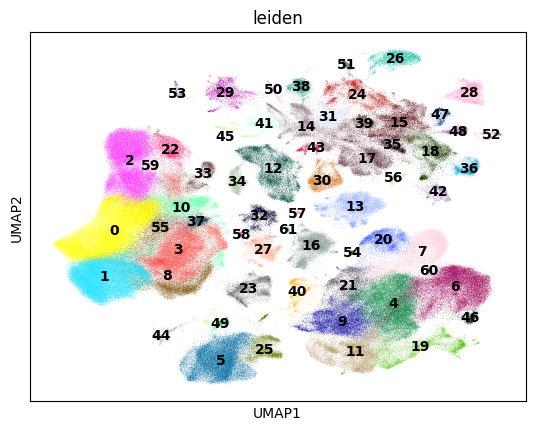

In [4]:
sc.pl.umap(adata,color=['leiden'], legend_loc="on data")

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


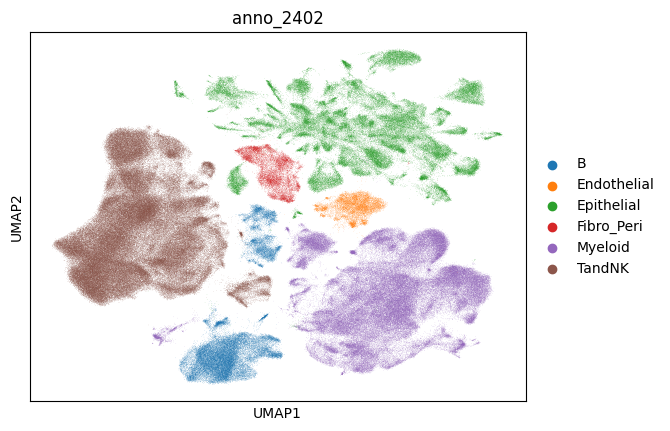

In [12]:
sc.pl.umap(adata,color=['anno_2402'])

In [9]:
# 'anno_2402' 열을 'anno_cat' 컬럼의 값으로 초기화
adata.obs['anno_2402'] = adata.obs['anno_cat']

# 'anno_2402' 열을 카테고리형으로 변환
adata.obs['anno_2402'] = adata.obs['anno_2402'].astype('category')

# 'Epi_or_Tumor' 카테고리 이름을 'Epithelial'로 변경
adata.obs['anno_2402'] = adata.obs['anno_2402'].cat.rename_categories({'Epi_or_Tumor': 'Epithelial'})

# # 'tumor' 카테고리를 추가
# if 'tumor' not in adata.obs['anno_2402'].cat.categories:
#     adata.obs['anno_2402'] = adata.obs['anno_2402'].cat.add_categories(['tumor'])

# 'anno_cat' 값이 'FibroEndoPeri'이고 'anno_2212' 값이 'Endothelial'인 경우 'Endothelial'로 설정
# 그렇지 않은 경우 'Fibro_Peri'로 설정
adata.obs['anno_2402'] = adata.obs.apply(
    lambda row: 'Endothelial' if row['anno_cat'] == 'FibroEndoPeri' and row['anno_2212'] == 'Endothelial' else (
        'Fibro_Peri' if row['anno_cat'] == 'FibroEndoPeri' else row['anno_2402']
    ), axis=1
)

for cluster in [13]:
    adata.obs.loc[adata.obs['leiden'] == str(cluster), 'anno_2402'] = 'Endothelial'

In [13]:
adata.obs.cell_type_major = adata.obs.anno_2402

In [14]:
adata.obs

n_counts  n_genes  \
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...    7088.0     2072   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...    4985.0     1269   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...   10007.0     2543   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...   18045.0     4597   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...    4937.0     1492   
...                                                      ...      ...   
pan_bluprint_lung_scrBT1432_TTTGCGCAGAGACTTA          2749.0      953   
pan_bluprint_lung_scrBT1432_TTTGCGCTCTTCAACT          6028.0     1639   
pan_bluprint_lung_scrBT1432_TTTGGTTCATTCTCAT          5192.0     1419   
pan_bluprint_lung_scrBT1432_TTTGTCACACATGTGT          1760.0      625   
pan_bluprint_lung_scrBT1432_TTTGTCATCGCGGATC          6131.0      766   

                                                        mito  doublet_scores  \
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...  0.047256        0.071633   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...  0.024067        0.030362   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...  0.049760        0.085714   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...  0.040231        0.062750   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...  0.034629        0.013503   
...                                                      ...             ...   
pan_bluprint_lung_scrBT1432_TTTGCGCAGAGACTTA        0.031273        0.062446   
pan_bluprint_lung_scrBT1432_TTTGCGCTCTTCAACT        0.023221        0.068031   
pan_bluprint_lung_scrBT1432_TTTGGTTCATTCTCAT        0.039091        0.024807   
pan_bluprint_lung_scrBT1432_TTTGTCACACATGTGT        0.021579        0.022342   
pan_bluprint_lung_scrBT1432_TTTGTCATCGCGGATC        0.008154        0.080119   

                                                    predicted_doublets  \
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...                True   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...                True   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...                True   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...                True   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...                True   
...                                                                ...   
pan_bluprint_lung_scrBT1432_TTTGCGCAGAGACTTA                      True   
pan_bluprint_lung_scrBT1432_TTTGCGCTCTTCAACT                      True   
pan_bluprint_lung_scrBT1432_TTTGGTTCATTCTCAT                      True   
pan_bluprint_lung_scrBT1432_TTTGTCACACATGTGT                      True   
pan_bluprint_lung_scrBT1432_TTTGTCATCGCGGATC                      True   

                                                                        Dataset  \
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...                pan_GSE140819   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...                pan_GSE140819   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...                pan_GSE140819   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...                pan_GSE140819   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...                pan_GSE140819   
...                                                                         ...   
pan_bluprint_lung_scrBT1432_TTTGCGCAGAGACTTA        lu_nsclc_pan_blueprint_lung   
pan_bluprint_lung_scrBT1432_TTTGCGCTCTTCAACT        lu_nsclc_pan_blueprint_lung   
pan_bluprint_lung_scrBT1432_TTTGGTTCATTCTCAT        lu_nsclc_pan_blueprint_lung   
pan_bluprint_lung_scrBT1432_TTTGTCACACATGTGT        lu_nsclc_pan_blueprint_lung   
pan_bluprint_lung_scrBT1432_TTTGTCATCGCGGATC        lu_nsclc_pan_blueprint_lung   

                                                           Anno_low Anno_high  \
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...       Macrophage       n/a   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...                T       n/a   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...       Macrophage       n/a   
pan_

In [15]:
# 'column1', 'column2', 'column3' 컬럼을 한 번에 삭제
re_list = ['doublet_scores', 'predicted_doublets', 'Anno_low', 'Anno_high', 'Platform', 'Meta_site', 'Treatment', 'Immunotherapy',
          'Response', 'CancerAbbr', 'OrgTis', 'Status', 'Sample_Origin', 'Diagnosis', 'anno_new', 'anno_final2207', 
           'anno_figure', 'anno_specific', 'anno_fig_specific', 'anno_2211', 'F1C', 'anno_cat', 'anno_2212']

adata.obs.drop(re_list, axis=1, inplace=True)

In [16]:
# # 'anno_cat'이 'TandNK'인 인덱스 추출
# tandnk_indexes = adata.obs[adata.obs['anno_cat'] == 'TandNK'].index

# 필터링 데이터셋
exclude_datasets = ['lu_sclc_GSE150766', 'pr_GSE143791']
exclude_pt = ['lu_adc_codeocean_p029']
# adata.obs에서 제외할 데이터셋 필터링
adata = adata[~adata.obs['Dataset'].isin(exclude_datasets)].copy()
adata = adata[~adata.obs['Patient'].isin(exclude_pt)].copy()

In [13]:
adata.obs.Dataset.value_counts()

Dataset
lu_adc_GSE131907               178644
lu_adc_codeocean               107191
lu_nsclc_pan_blueprint_lung     66571
lu_HRA000154                    57156
lu_adc_GSE123902                32234
pan_GSE140819                   17407
lung_hca_vieira                 12633
lu_adc_GSE146100                10515
Name: count, dtype: int64

### Cell type identification

In [7]:
## 데이터셋 별로 hicat
import pandas as pd

mkr_file = '/home/nccpml/DATA2/hanbyeol/TEC/cell_markers_rndsystems_hs.tsv'
# df_pred 및 summary 저장을 위한 빈 딕셔너리 초기화
df_pred_dict = {}
summary_dict = {}

# 데이터셋별로 반복
datasets = adata.obs['Dataset'].unique()
for dataset in datasets:
    # 현재 데이터셋 필터링
    current_adata = adata[adata.obs['Dataset'] == dataset].copy()

    target_tissues = [] # ['Immune', 'General']
    target_cell_types = ['T cell', 'B cell', 'Myeloid cell', 'Fibroblast','Mast cell',
                         'Epithelial cell', 'Endothelial cell'] 
    to_exclude = ['unassigned']
    
    # HiCAT 분석 수행
    df_pred, summary = \
        HiCAT(current_adata.to_df(), mkr_file, log_transformed=False,
               target_tissues = target_tissues, target_cell_types = target_cell_types, 
                   minor_types_to_exclude = to_exclude, mkr_selector = '100000', 
                   N_neighbors_minor = 31, N_neighbors_subset = 1,  
                   Clustering_algo = 'lv', Clustering_resolution = 1, 
                   Clustering_base = 'pca', N_pca_components = 15, 
                   cbc_cutoff = 0.01, Target_FPR = 0.05, pval_th = 0.05,
                   cycling_cell = False, copy_X = False, verbose = False )
       
    # 각 데이터셋의 결과에서 'cell_type_major', 'cell_type_minor', 'cell_type_subset' 컬럼 추출 및 adata.obs에 추가
    types_df = df_pred[['cell_type_major', 'cell_type_minor', 'cell_type_subset']]
    # 인덱스를 기존 adata.obs와 일치시킴
    types_df.index = current_adata.obs.index
    adata.obs.loc[types_df.index, ['cell_type_major', 'cell_type_minor', 'cell_type_subset']] = types_df

HiCAT running ...

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_xsm = xsm[odr[lc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_xsm = xsm[odr[uc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1229: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '131.93559034619886' has dtype incompatible with float32, please explicitly cast to a compatible 

P26.C1..

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '17/116' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = nlst
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6/35' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = nlst
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '22/85' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = nlst
/

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:2232: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  fpr, tpr, _ = roc_curve(y.ravel(), y_odd.ravel(), pos_label = target)
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:2232: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  fpr, tpr, _ = roc_curve(y.ravel(), y_odd.ravel(), pos_label = target)
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:2232: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  fpr, tpr, _ = roc_curve(y.ravel(), y_odd.ravel(), pos_label = target)
/home/hanbyeol/.conda/envs/p

M36.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:2232: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  fpr, tpr, _ = roc_curve(y.ravel(), y_odd.ravel(), pos_label = target)
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:2232: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  fpr, tpr, _ = roc_curve(y.ravel(), y_odd.ravel(), pos_label = target)
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:2232: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  fpr, tpr, _ = roc_curve(y.ravel(), y_odd.ravel(), pos_label = target)
/home/hanbyeol/.conda/envs/p

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[5.67390248 6.04168485 3.7714844  ... 1.96013586 4.11945461 5.30140224]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_GSA_score_minor_all.loc[idxs, cols] = df_GSA_score_cur
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.27947295 2.42076884 0.82144778 ... 1.53541238 1.85859837 1.84785973]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_GSA_score_minor_all.loc[idxs, cols] = df_GSA_score_cur
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of incompa

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 2.11366391  3.07102651  1.69664437  4.80839241  3.14116347  3.67929666
  5.41461791  1.69297373  4.99274358  2.26762972  6.26955055  4.92808229
  8.21165301  1.62242465  1.67104111  4.05970211  3.99395966  3.85265208
  5.14560558  5.26375811  3.99851077  1.77613572  6.45811471  1.24564905
  5.26375811  1.40133352  1.5152006   4.76864327  5.35293501  3.31387442
  3.13852302  1.72364033  4.09791708  3.93813023  1.69534359  2.59606013
  2.80682203  2.59145212  2.85431757  3.98942138  3.83905223  5.95862878
  4.96199434  2.87246973  6.91735787  2.86198476  1.46077839  2.01936033
  4.27012781  1.61173796  7.1647931   0.4252841   4.66668711  2.00653301
  5.77108877  5.87018024  0.66936028  1.10320385  1.20151039  3.45520712
  3.92066647  2.0175185   8.39360036  2.67731816  4.21

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 8.23293352  8.58737855  5.08949649 ... 10.54623065  1.51947008
  8.14026209]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_GSA_score_minor_all.loc[idxs, cols] = df_GSA_score_cur
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.92955863 3.36331411 3.3454748  ... 3.69722647 0.90365945 2.22420689]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_GSA_score_minor_all.loc[idxs, cols] = df_GSA_score_cur
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of 

M45.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_xsm = xsm[odr[lc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_xsm = xsm[odr[uc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1229: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '39.344631145812' has dtype incompatible with float32, please explicitly cast to a compatible dty

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_xsm = xsm[odr[lc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_xsm = xsm[odr[uc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1229: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '21.587033144922902' has dtype incompatible with float32, please explicitly cast to a compatible 

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4/13' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = nlst
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2/14' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = nlst
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2/12' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = nlst
/home/hanb

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3/13' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = nlst
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2/14' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = nlst
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_xsm = xsm[odr[l

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_xsm = xsm[odr[lc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_xsm = xsm[odr[uc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1229: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '15.0996688705415' has dtype incompatible with float32, please explicitly cast to a compatible dt

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1/19' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = nlst
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0/8' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = nlst
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '7/11' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = nlst


S32. done. (140)


/tmp/ipykernel_878620/731547066.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['Myeloid cell' 'T cell' 'Myeloid cell' ... 'Endothelial cell'
 'Endothelial cell' 'Endothelial cell']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  adata.obs.loc[types_df.index, ['cell_type_major', 'cell_type_minor', 'cell_type_subset']] = types_df
/tmp/ipykernel_878620/731547066.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['Macrophage' 'T cell CD4+' 'Macrophage' ... 'Endothelial cell'
 'Endothelial cell' 'Endothelial cell']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  adata.obs.loc[types_df.index, ['cell_type_major', 'cell_type_minor', 'cell_type_subset']] = types_df
/tmp/ipykernel_878620/731547066.py:35: FutureWarning: Setting an item o

HiCAT running ...

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_xsm = xsm[odr[lc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_xsm = xsm[odr[uc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1229: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '179.53829675030337' has dtype incompatible with float32, please explicitly cast to a compatible 

P53.C6.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5/116' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = nlst
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2/35' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = nlst
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2/85' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = nlst
/ho

..

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:2232: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  fpr, tpr, _ = roc_curve(y.ravel(), y_odd.ravel(), pos_label = target)
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:2232: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  fpr, tpr, _ = roc_curve(y.ravel(), y_odd.ravel(), pos_label = target)
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:2232: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  fpr, tpr, _ = roc_curve(y.ravel(), y_odd.ravel(), pos_label = target)
/home/hanbyeol/.conda/envs/p

M62.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:2232: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  fpr, tpr, _ = roc_curve(y.ravel(), y_odd.ravel(), pos_label = target)
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:2232: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  fpr, tpr, _ = roc_curve(y.ravel(), y_odd.ravel(), pos_label = target)
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:2232: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  fpr, tpr, _ = roc_curve(y.ravel(), y_odd.ravel(), pos_label = target)
/home/hanbyeol/.conda/envs/p

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.72257342 4.17175152 7.78479717 ... 3.31059049 4.40521026 4.58050119]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_GSA_score_minor_all.loc[idxs, cols] = df_GSA_score_cur
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 2.74390031  5.00192614  3.81816458 ...  4.3249643  11.24476269
  1.51963347]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_GSA_score_minor_all.loc[idxs, cols] = df_GSA_score_cur
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of 

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.90287202 0.60583389 1.80706491 ... 4.49281616 1.88109517 4.57509694]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_GSA_score_minor_all.loc[idxs, cols] = df_GSA_score_cur
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.90177047  4.3831325  -0.         ...  2.03004807  0.89101564
  2.07058155]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_GSA_score_minor_all.loc[idxs, cols] = df_GSA_score_cur
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1200: FutureWarning: Series.__getitem__ 

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 6.83779585  8.35844825 12.02059822 ...  6.26686503  7.85996993
  8.34878175]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_GSA_score_minor_all.loc[idxs, cols] = df_GSA_score_cur
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.53357029 2.34894444 3.98277846 ... 3.58436004 4.16603495 3.31386701]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_GSA_score_minor_all.loc[idxs, cols] = df_GSA_score_cur
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of 

M145.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_xsm = xsm[odr[lc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_xsm = xsm[odr[uc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1229: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '81.8535277187245' has dtype incompatible with float32, please explicitly cast to a compatible dt

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_xsm = xsm[odr[lc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_xsm = xsm[odr[uc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1229: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '48.86716689148246' has dtype incompatible with float32, please explicitly cast to a compatible d

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_xsm = xsm[odr[lc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_xsm = xsm[odr[uc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1229: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '42.50882261366456' has dtype incompatible with float32, please explicitly cast to a compatible d

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_xsm = xsm[odr[lc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_xsm = xsm[odr[uc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1229: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '84.20807562223472' has dtype incompatible with float32, please explicitly cast to a compatible d

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_xsm = xsm[odr[lc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_xsm = xsm[odr[uc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1229: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '18.275666882497067' has dtype incompatible with float32, please explicitly cast to a compatible 

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2/19' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = nlst
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0/8' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = nlst
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0/11' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = nlst


S63. done. (330)
HiCAT running ...

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_xsm = xsm[odr[lc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_xsm = xsm[odr[uc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1229: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '239.07321054438535' has dtype incompatible with float32, please explicitly cast to a compatible 

P85.C18.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '22/116' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = nlst
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2/35' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = nlst
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '7/85' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = nlst
/h

..

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:2232: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  fpr, tpr, _ = roc_curve(y.ravel(), y_odd.ravel(), pos_label = target)
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:2232: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  fpr, tpr, _ = roc_curve(y.ravel(), y_odd.ravel(), pos_label = target)
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:2232: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  fpr, tpr, _ = roc_curve(y.ravel(), y_odd.ravel(), pos_label = target)
/home/hanbyeol/.conda/envs/p

M107.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:2232: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  fpr, tpr, _ = roc_curve(y.ravel(), y_odd.ravel(), pos_label = target)
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:2232: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  fpr, tpr, _ = roc_curve(y.ravel(), y_odd.ravel(), pos_label = target)
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:2232: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  fpr, tpr, _ = roc_curve(y.ravel(), y_odd.ravel(), pos_label = target)
/home/hanbyeol/.conda/envs/p

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.48320702 3.39379144 2.80826446 ... 5.27153492 3.40212098 2.1549937 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_GSA_score_minor_all.loc[idxs, cols] = df_GSA_score_cur
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[12.44262437  2.8427528   3.22831896 ...  3.98487642  1.75860931
  0.82519556]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_GSA_score_minor_all.loc[idxs, cols] = df_GSA_score_cur
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of 

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.03456032 0.77631976 1.93287322 ... 1.44368065 1.25128309 0.66081356]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_GSA_score_minor_all.loc[idxs, cols] = df_GSA_score_cur
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.38246925 0.88134891 0.79285727 ... 5.38446187 2.56269773 0.76287551]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_GSA_score_minor_all.loc[idxs, cols] = df_GSA_score_cur
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1200: FutureWarning: Series.__getitem__ treatin

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[6.27735527 6.42876875 3.80789755 ... 7.77692761 0.91180849 0.21926764]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_GSA_score_minor_all.loc[idxs, cols] = df_GSA_score_cur
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[5.1701624  2.19586216 1.27904121 ... 2.99039848 0.57914115 0.49135713]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_GSA_score_minor_all.loc[idxs, cols] = df_GSA_score_cur
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of incompa

M255.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_xsm = xsm[odr[lc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_xsm = xsm[odr[uc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1229: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '111.57508682497182' has dtype incompatible with float32, please explicitly cast to a compatible 

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_xsm = xsm[odr[lc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_xsm = xsm[odr[uc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1229: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '70.50531894828929' has dtype incompatible with float32, please explicitly cast to a compatible d

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_xsm = xsm[odr[lc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_xsm = xsm[odr[uc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1229: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '67.09694478886502' has dtype incompatible with float32, please explicitly cast to a compatible d

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_xsm = xsm[odr[lc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_xsm = xsm[odr[uc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1229: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '50.18964036531842' has dtype incompatible with float32, please explicitly cast to a compatible d

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_xsm = xsm[odr[lc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_xsm = xsm[odr[uc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1229: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '13.892443989449804' has dtype incompatible with float32, please explicitly cast to a compatible 

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2/19' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = nlst
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2/8' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = nlst
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0/11' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = nlst


S79. done. (544)
HiCAT running ...

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_xsm = xsm[odr[lc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_xsm = xsm[odr[uc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1229: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '112.39661916623649' has dtype incompatible with float32, please explicitly cast to a compatible 

P19.C1..

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '10/116' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = nlst
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5/35' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = nlst
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '15/85' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = nlst
/

.M29.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:2232: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  fpr, tpr, _ = roc_curve(y.ravel(), y_odd.ravel(), pos_label = target)
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:2232: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  fpr, tpr, _ = roc_curve(y.ravel(), y_odd.ravel(), pos_label = target)
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:2232: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  fpr, tpr, _ = roc_curve(y.ravel(), y_odd.ravel(), pos_label = target)
/home/hanbyeol/.conda/envs/p

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 3.58560535  0.89633619  2.94619209  8.66339488  2.9377094   1.1834832
  5.95426556 10.10970071  7.51895224  4.3682726   3.23095564  4.89776731
  7.92969394  6.25309135 10.8975307   4.70137792  4.39110445  1.88280433
  1.77229639  1.89733328  5.0666971   4.17397334  2.02202429  4.99174666
  3.08001583  3.12690506  2.39460802  2.0809891   6.97323882  3.8408185
  4.69299769  8.24251225  7.1543787   4.79156013  6.51644537  4.48523549
  5.73458168  4.31253363  3.69612414  4.51966447  3.85554373  4.50237542
  4.76306536  4.74358362  5.94889454  6.12827993  4.27063766  8.74117404
  6.09692085  9.12961932  4.40760769  6.49389012  4.06371087  5.7209143
  5.72302584  5.62889631  2.93048556  6.2755494   2.5551943   6.03163278
  1.18126819  7.87147046  6.46230903  7.2579669   4.08887

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[8.05810354 3.45097586 3.44259791 1.4785796  1.86758087 2.31854044
 0.5597515  2.69888003 0.60678912 2.21482916 0.62590252 2.15642467
 1.85432159 1.42270989 0.62355101 2.36701354 0.60530594 3.52215698
 3.40835593 2.62286504 2.16356059 2.94938892 0.5092083  0.54464692
 1.43382797 2.67630149 1.46676722 1.55783441 1.25115877 4.90797971
 6.42582268 1.51754358 1.28333027 3.81634854 2.46537884 2.50119234
 1.22196585 5.5247254  1.23402453]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_GSA_score_minor_all.loc[idxs, cols] = df_GSA_score_cur
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys wi

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[5.24719369 3.93564171 2.87902063 ... 6.26478032 6.66545303 6.18613977]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_GSA_score_minor_all.loc[idxs, cols] = df_GSA_score_cur
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.9622332  1.35630425 2.48730993 ... 2.67076922 1.30682445 4.8975185 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_GSA_score_minor_all.loc[idxs, cols] = df_GSA_score_cur
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of incompa

M43.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_xsm = xsm[odr[lc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_xsm = xsm[odr[uc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1229: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '15.684387141358123' has dtype incompatible with float32, please explicitly cast to a compatible 

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1/8' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = nlst
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2/19' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = nlst
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1/15' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = nlst
/home/hanby

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1247: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s_th = sr[odr[-N_genes]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2/13' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = nlst
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1/14' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] =

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_xsm = xsm[odr[lc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_xsm = xsm[odr[uc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1229: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '87.08042259888269' has dtype incompatible with float32, please explicitly cast to a compatible d

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_xsm = xsm[odr[lc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_xsm = xsm[odr[uc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1229: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5.830951894845301' has dtype incompatible with float32, please explicitly cast to a compatible d

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1247: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s_th = sr[odr[-N_genes]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '7/19' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = nlst
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3/8' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = 

S38. done. (130)
HiCAT running ...

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_xsm = xsm[odr[lc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_xsm = xsm[odr[uc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1229: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '422.6629863141555' has dtype incompatible with float32, please explicitly cast to a compatible d

P265.C151.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9/116' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = nlst
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9/35' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = nlst
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4/85' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = nlst
/ho

..

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:2232: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  fpr, tpr, _ = roc_curve(y.ravel(), y_odd.ravel(), pos_label = target)
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:2232: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  fpr, tpr, _ = roc_curve(y.ravel(), y_odd.ravel(), pos_label = target)
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:2232: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  fpr, tpr, _ = roc_curve(y.ravel(), y_odd.ravel(), pos_label = target)
/home/hanbyeol/.conda/envs/p

M340.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:2232: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  fpr, tpr, _ = roc_curve(y.ravel(), y_odd.ravel(), pos_label = target)
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:2232: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  fpr, tpr, _ = roc_curve(y.ravel(), y_odd.ravel(), pos_label = target)
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:2232: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  fpr, tpr, _ = roc_curve(y.ravel(), y_odd.ravel(), pos_label = target)
/home/hanbyeol/.conda/envs/p

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.86217775 8.16552989 6.51931697 ... 5.28272145 7.53865556 2.56308787]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_GSA_score_minor_all.loc[idxs, cols] = df_GSA_score_cur
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.43411788 1.52137022 5.62733889 ... 3.93712706 2.34585652 2.97863979]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_GSA_score_minor_all.loc[idxs, cols] = df_GSA_score_cur
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of incompa

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.73624129 9.87680703 7.65289789 ... 7.54082432 4.59710296 6.49231124]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_GSA_score_minor_all.loc[idxs, cols] = df_GSA_score_cur
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[5.83963276 4.94222305 0.59980183 ... 1.47264973 2.66763632 0.65674952]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_GSA_score_minor_all.loc[idxs, cols] = df_GSA_score_cur
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1200: FutureWarning: Series.__getitem__ treatin

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.64859563 2.06753528 6.72389569 ... 2.74262188 8.81554624 5.54812902]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_GSA_score_minor_all.loc[idxs, cols] = df_GSA_score_cur
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.10411597 1.81618393 5.00931612 ... 2.03329515 3.69172448 1.45047729]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_GSA_score_minor_all.loc[idxs, cols] = df_GSA_score_cur
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of incompa

M845.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_xsm = xsm[odr[lc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_xsm = xsm[odr[uc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1229: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '200.54176622339796' has dtype incompatible with float32, please explicitly cast to a compatible 

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_xsm = xsm[odr[lc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_xsm = xsm[odr[uc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1229: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '78.11529939774923' has dtype incompatible with float32, please explicitly cast to a compatible d

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_xsm = xsm[odr[lc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_xsm = xsm[odr[uc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1229: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '138.02535998866296' has dtype incompatible with float32, please explicitly cast to a compatible 

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_xsm = xsm[odr[lc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_xsm = xsm[odr[uc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1229: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '187.70455508591155' has dtype incompatible with float32, please explicitly cast to a compatible 

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_xsm = xsm[odr[lc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_xsm = xsm[odr[uc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1229: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '37.04051835490427' has dtype incompatible with float32, please explicitly cast to a compatible d

.S351. done. (1952)
HiCAT running ...

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_xsm = xsm[odr[lc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_xsm = xsm[odr[uc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1229: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '327.40036652392433' has dtype incompatible with float32, please explicitly cast to a compatible 

P158.C33.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '7/116' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = nlst
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9/35' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = nlst
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5/85' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = nlst
/ho

..

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:2232: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  fpr, tpr, _ = roc_curve(y.ravel(), y_odd.ravel(), pos_label = target)
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:2232: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  fpr, tpr, _ = roc_curve(y.ravel(), y_odd.ravel(), pos_label = target)
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:2232: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  fpr, tpr, _ = roc_curve(y.ravel(), y_odd.ravel(), pos_label = target)
/home/hanbyeol/.conda/envs/p

M219.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:2232: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  fpr, tpr, _ = roc_curve(y.ravel(), y_odd.ravel(), pos_label = target)
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:2232: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  fpr, tpr, _ = roc_curve(y.ravel(), y_odd.ravel(), pos_label = target)
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:2232: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  fpr, tpr, _ = roc_curve(y.ravel(), y_odd.ravel(), pos_label = target)
/home/hanbyeol/.conda/envs/p

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.30360106 4.75494789 1.28097569 ... 0.87360747 4.9681847  2.44033358]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_GSA_score_minor_all.loc[idxs, cols] = df_GSA_score_cur
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.66045452 4.10535484 0.66540168 ... 2.28534954 1.70348464 1.13021894]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_GSA_score_minor_all.loc[idxs, cols] = df_GSA_score_cur
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of incompa

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 1.99385406  2.42232344  4.70350265 ... -0.          2.67950512
  3.1046065 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_GSA_score_minor_all.loc[idxs, cols] = df_GSA_score_cur
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 8.31372761 10.52206207  0.63345813 ...  2.54924187  9.45380059
  0.52846675]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_GSA_score_minor_all.loc[idxs, cols] = df_GSA_score_cur
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1200: FutureWarning: Series.__get

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[10.31004664  7.2856615   8.61900128 ... 15.0237705  10.36297661
  5.71702188]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_GSA_score_minor_all.loc[idxs, cols] = df_GSA_score_cur
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.14129679 1.2346819  6.92849116 ... 6.40464284 2.88342607 1.43403101]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_GSA_score_minor_all.loc[idxs, cols] = df_GSA_score_cur
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of 

M480.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_xsm = xsm[odr[lc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_xsm = xsm[odr[uc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1229: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '124.90396310766124' has dtype incompatible with float32, please explicitly cast to a compatible 

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_xsm = xsm[odr[lc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_xsm = xsm[odr[uc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1229: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '54.83611948342078' has dtype incompatible with float32, please explicitly cast to a compatible d

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_xsm = xsm[odr[lc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_xsm = xsm[odr[uc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1229: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '54.35071296680477' has dtype incompatible with float32, please explicitly cast to a compatible d

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_xsm = xsm[odr[lc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_xsm = xsm[odr[uc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1229: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '197.35501007068456' has dtype incompatible with float32, please explicitly cast to a compatible 

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_xsm = xsm[odr[lc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_xsm = xsm[odr[uc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1229: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '32.92415526630866' has dtype incompatible with float32, please explicitly cast to a compatible d

.S220. done. (1109)
HiCAT running ...

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_xsm = xsm[odr[lc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_xsm = xsm[odr[uc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1229: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '102.5426740435415' has dtype incompatible with float32, please explicitly cast to a compatible d

P16.C1.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '26/116' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = nlst
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4/35' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = nlst
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4/85' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = nlst
/h

..

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:2232: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  fpr, tpr, _ = roc_curve(y.ravel(), y_odd.ravel(), pos_label = target)
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:2232: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  fpr, tpr, _ = roc_curve(y.ravel(), y_odd.ravel(), pos_label = target)
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:2232: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  fpr, tpr, _ = roc_curve(y.ravel(), y_odd.ravel(), pos_label = target)
/home/hanbyeol/.conda/envs/p

M24.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:2232: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  fpr, tpr, _ = roc_curve(y.ravel(), y_odd.ravel(), pos_label = target)
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_xsm = xsm[odr[lc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_xsm = x

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.48080878 7.46486393 5.28113986 ... 3.92378471 3.88724572 4.78472578]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_GSA_score_minor_all.loc[idxs, cols] = df_GSA_score_cur
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[8.30127976 3.436449   3.16761009 ... 7.54594076 5.52181245 2.3956094 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_GSA_score_minor_all.loc[idxs, cols] = df_GSA_score_cur
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of incompa

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 5.63030089  4.87995882  5.07208289  3.55720967  5.90994764  4.91366365
  3.17186011  3.2318083   7.76706395  4.53660952  3.8540371   7.36082125
  8.10482783  5.81900414  4.99626817  6.5503252   7.49471228  2.69896644
  5.85006296  3.91621145  2.63352755  3.72201693  5.87769991  5.29671792
  5.80372944  6.70467156  3.98682515  3.1202496   3.72080248  4.10828067
  4.74279824  1.69618387  4.86545355  4.52251224  3.04267172  3.83197649
  4.77189887  4.00909138  3.64959077  3.60198061  4.12552744  2.93233697
  4.0744339   4.37327422  6.98758934  4.04547295  2.45680287  5.52441164
  3.73420428  3.5468777   4.8338531   3.21880619  6.99485767  4.67126052
  4.99608416  4.51414326  5.89045332  2.43802019  3.67166632  5.15508803
  4.73231887  5.49782978  9.07220033  5.1089504   5.66

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[11.82704781 13.07067071 12.76756299 ...  7.30173701 12.4694452
  6.31851201]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_GSA_score_minor_all.loc[idxs, cols] = df_GSA_score_cur
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.53817669 2.50574093 5.45006756 ... 1.74747403 3.50550692 1.63192869]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_GSA_score_minor_all.loc[idxs, cols] = df_GSA_score_cur
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of i

M56.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_xsm = xsm[odr[lc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_xsm = xsm[odr[uc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1229: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '52.85830114561004' has dtype incompatible with float32, please explicitly cast to a compatible d

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_xsm = xsm[odr[lc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_xsm = xsm[odr[uc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1229: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '21.6794833886788' has dtype incompatible with float32, please explicitly cast to a compatible dt

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4/13' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = nlst
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2/14' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = nlst
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3/12' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = nlst
/home/hanb

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6/13' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = nlst
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6/14' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = nlst
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '7/14' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = nlst
/home/hanb

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_xsm = xsm[odr[lc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_xsm = xsm[odr[uc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1229: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '8.12403840463596' has dtype incompatible with float32, please explicitly cast to a compatible dt

.S30.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '8/19' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = nlst
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2/8' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = nlst
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6/11' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = nlst


 done. (127)
HiCAT running ...

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_xsm = xsm[odr[lc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_xsm = xsm[odr[uc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1229: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '258.0135655348377' has dtype incompatible with float32, please explicitly cast to a compatible d

P98.C17.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4/116' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = nlst
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0/35' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = nlst
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6/85' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = nlst
/ho

..

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:2232: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  fpr, tpr, _ = roc_curve(y.ravel(), y_odd.ravel(), pos_label = target)
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:2232: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  fpr, tpr, _ = roc_curve(y.ravel(), y_odd.ravel(), pos_label = target)
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:2232: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  fpr, tpr, _ = roc_curve(y.ravel(), y_odd.ravel(), pos_label = target)
/home/hanbyeol/.conda/envs/p

M128.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:2232: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  fpr, tpr, _ = roc_curve(y.ravel(), y_odd.ravel(), pos_label = target)
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:2232: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  fpr, tpr, _ = roc_curve(y.ravel(), y_odd.ravel(), pos_label = target)
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:2232: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  fpr, tpr, _ = roc_curve(y.ravel(), y_odd.ravel(), pos_label = target)
/home/hanbyeol/.conda/envs/p

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.63726795 8.90150086 3.86692926 ... 6.76054656 5.34127002 6.33049717]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_GSA_score_minor_all.loc[idxs, cols] = df_GSA_score_cur
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[12.73168168  4.41495109  2.36495956 ...  4.24267608  7.52194033
  4.64161209]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_GSA_score_minor_all.loc[idxs, cols] = df_GSA_score_cur
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of 

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.67400615 0.83076386 3.13194178 ... 4.69142874 1.57760637 1.54496484]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_GSA_score_minor_all.loc[idxs, cols] = df_GSA_score_cur
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.77645554  8.61776633 10.13766632 ...  0.59798711  4.53525788
  7.83025833]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_GSA_score_minor_all.loc[idxs, cols] = df_GSA_score_cur
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1200: FutureWarning: Series.__getitem__ 

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 3.02458399 11.59687237  6.79339483 ...  3.82349478 13.69638158
  3.5710926 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_GSA_score_minor_all.loc[idxs, cols] = df_GSA_score_cur
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.52291607 4.12814269 3.63400433 ... 3.92607964 5.90077339 1.25779743]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_GSA_score_minor_all.loc[idxs, cols] = df_GSA_score_cur
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of 

M278.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_xsm = xsm[odr[lc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_xsm = xsm[odr[uc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1229: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '103.60984509205677' has dtype incompatible with float32, please explicitly cast to a compatible 

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_xsm = xsm[odr[lc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_xsm = xsm[odr[uc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1229: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '46.57252408878007' has dtype incompatible with float32, please explicitly cast to a compatible d

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_xsm = xsm[odr[lc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_xsm = xsm[odr[uc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1229: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '59.55669567731239' has dtype incompatible with float32, please explicitly cast to a compatible d

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_xsm = xsm[odr[lc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_xsm = xsm[odr[uc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1229: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '134.30562162471085' has dtype incompatible with float32, please explicitly cast to a compatible 

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_xsm = xsm[odr[lc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_xsm = xsm[odr[uc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1229: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '23.280893453645632' has dtype incompatible with float32, please explicitly cast to a compatible 

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2/19' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = nlst
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0/8' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = nlst
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1433: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0/11' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfn.iloc[i] = nlst


S112. done. (634)


In [64]:
path = '/home/nccpml/DATA2/hanbyeol/TEC/h5ad_data/'
adata.write(path + 'CCA_Lung_0417.h5ad')

In [51]:
path = '/home/nccpml/DATA2/hanbyeol/TEC/h5ad_data/'
adata = sc.read(path+'CCA_Lung_0416.h5ad')

In [21]:
# # cell_type_major 열의 값 카운트
cell_type_counts = adata.obs['cell_type_major'].value_counts()

# # 0이 아닌 카운트를 가진 카테고리만 선택
# non_zero_cell_types = cell_type_counts[cell_type_counts > 0].index

# # 0이 아닌 카테고리만을 가진 데이터프레임 생성
# adata = adata[adata.obs['cell_type_major'].isin(non_zero_cell_types)].copy()

# adata.obs.cell_type_major.value_counts()

In [47]:
cell_type_counts

cell_type_major
T cell              199697
Myeloid cell        121701
Epithelial cell      86834
B cell               40662
Fibroblast           12278
Endothelial cell     10099
Mast cell             9830
unassigned            1250
Name: count, dtype: int64

In [52]:
# 'unassigned' 값을 'Epithelial cell'로 변경
adata.obs['cell_type_major'].replace('unassigned', 'Epithelial cell', inplace=True)
adata.obs['cell_type_major'].replace('T cell', 'T', inplace=True)
adata.obs['cell_type_major'].replace('Myeloid cell', 'Myeloid', inplace=True)
adata.obs['cell_type_major'].replace('Epithelial cell', 'Epi', inplace=True)
adata.obs['cell_type_major'].replace('Fibroblast', 'Fibroblast', inplace=True)
adata.obs['cell_type_major'].replace('Endothelial cell', 'Endo', inplace=True)
adata.obs['cell_type_major'].replace('Mast cell', 'Mast', inplace=True)
adata.obs['cell_type_major'].replace('B cell', 'B', inplace=True)

# 변경 후의 값 분포 확인
adata.obs['cell_type_major'].value_counts()


/tmp/ipykernel_878620/3864764209.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  adata.obs['cell_type_major'].replace('unassigned', 'Epithelial cell', inplace=True)
/tmp/ipykernel_878620/3864764209.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs['cell_type_major'].replace('unassigned', 'Epithelial 

cell_type_major
T             199697
Myeloid       121701
Epi            88084
B              40662
Fibroblast     12278
Endo           10099
Mast            9830
Name: count, dtype: int64

In [60]:
# 'leiden' 클러스터 44에 해당하는 세포의 인덱스를 찾기
cluster_indices = adata.obs['leiden'] == '44'

# 이 인덱스에 해당하는 'cell_type_major'를 'Myeloid'로 설정
adata.obs.loc[cluster_indices, 'cell_type_major'] = 'Myeloid'

# 변경 사항 확인
adata.obs['cell_type_major'].value_counts()


cell_type_major
T             199542
Myeloid       121878
Epi            88080
B              40644
Fibroblast     12278
Endo           10099
Mast            9830
Name: count, dtype: int64

In [63]:
adata.obs

n_counts  n_genes  \
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...    7088.0     2072   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...    4985.0     1269   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...   10007.0     2543   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...   18045.0     4597   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...    4937.0     1492   
...                                                      ...      ...   
pan_bluprint_lung_scrBT1432_TTTGCGCAGAGACTTA          2749.0      953   
pan_bluprint_lung_scrBT1432_TTTGCGCTCTTCAACT          6028.0     1639   
pan_bluprint_lung_scrBT1432_TTTGGTTCATTCTCAT          5192.0     1419   
pan_bluprint_lung_scrBT1432_TTTGTCACACATGTGT          1760.0      625   
pan_bluprint_lung_scrBT1432_TTTGTCATCGCGGATC          6131.0      766   

                                                        mito  doublet_scores  \
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...  0.047256        0.071633   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...  0.024067        0.030362   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...  0.049760        0.085714   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...  0.040231        0.062750   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...  0.034629        0.013503   
...                                                      ...             ...   
pan_bluprint_lung_scrBT1432_TTTGCGCAGAGACTTA        0.031273        0.062446   
pan_bluprint_lung_scrBT1432_TTTGCGCTCTTCAACT        0.023221        0.068031   
pan_bluprint_lung_scrBT1432_TTTGGTTCATTCTCAT        0.039091        0.024807   
pan_bluprint_lung_scrBT1432_TTTGTCACACATGTGT        0.021579        0.022342   
pan_bluprint_lung_scrBT1432_TTTGTCATCGCGGATC        0.008154        0.080119   

                                                    predicted_doublets  \
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...                True   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...                True   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...                True   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...                True   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...                True   
...                                                                ...   
pan_bluprint_lung_scrBT1432_TTTGCGCAGAGACTTA                      True   
pan_bluprint_lung_scrBT1432_TTTGCGCTCTTCAACT                      True   
pan_bluprint_lung_scrBT1432_TTTGGTTCATTCTCAT                      True   
pan_bluprint_lung_scrBT1432_TTTGTCACACATGTGT                      True   
pan_bluprint_lung_scrBT1432_TTTGTCATCGCGGATC                      True   

                                                                        Dataset  \
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...                pan_GSE140819   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...                pan_GSE140819   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...                pan_GSE140819   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...                pan_GSE140819   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...                pan_GSE140819   
...                                                                         ...   
pan_bluprint_lung_scrBT1432_TTTGCGCAGAGACTTA        lu_nsclc_pan_blueprint_lung   
pan_bluprint_lung_scrBT1432_TTTGCGCTCTTCAACT        lu_nsclc_pan_blueprint_lung   
pan_bluprint_lung_scrBT1432_TTTGGTTCATTCTCAT        lu_nsclc_pan_blueprint_lung   
pan_bluprint_lung_scrBT1432_TTTGTCACACATGTGT        lu_nsclc_pan_blueprint_lung   
pan_bluprint_lung_scrBT1432_TTTGTCATCGCGGATC        lu_nsclc_pan_blueprint_lung   

                                                           Anno_low Anno_high  \
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...       Macrophage       n/a   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...                T       n/a   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...       Macrophage       n/a   
pan_

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


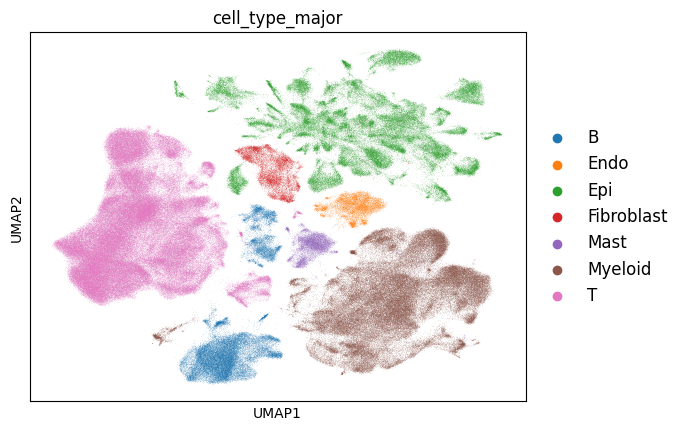

In [61]:
sc.pl.umap(adata, color=['cell_type_major'], legend_fontsize = 12)

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'leiden'}, xlabel='UMAP1', ylabel='UMAP2'>

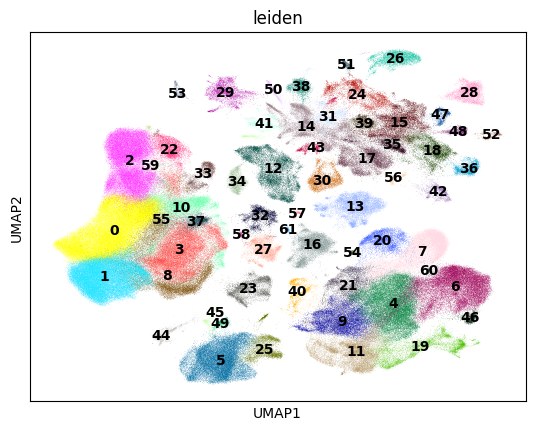

In [10]:
sc.pl.umap(adata, color="leiden", legend_loc="on data", show=False)

In [32]:
## 클러스터를 통째로 같은 세포로 설정
B = [32, 27, 45, 49, 25, 5]
T = [1, 8, 0, 55, 3, 37, 2, 59, 22, 33, 58, 23, 57, 10]
endo = [13]
epi = [53, 50, 38, 51, 26, 41, 14, 31, 24, 43, 39, 15, 47, 28, 17, 35, 18, 56, 42, 36, 48, 52, 34, 29, 30]
fib = [12]
mast = [16, 61]
myeloid = [54, 20, 7, 44, 40, 21, 60, 9, 4, 6, 11, 19, 46]

In [33]:
len(B)+len(T)+len(endo)+len(epi)+len(fib)+len(mast)+len(myeloid)

62

In [34]:
# 중복된 클러스터 번호 찾기
# Define the combined list of all numbers provided in the groups
combined_list = B + T + endo + epi + fib + mast + myeloid

from collections import Counter
cluster_counts = Counter(combined_list)
duplicates = {cluster: count for cluster, count in cluster_counts.items() if count > 1}
duplicates

{}

In [35]:
# Create a set of all numbers from 1 to 61
all_numbers = set(range(0, 62))

# Find the missing numbers by subtracting the combined set from the set of all numbers
missing_numbers1 = all_numbers - set(combined_list)
missing_numbers2 = set(combined_list) - all_numbers
missing_numbers1, missing_numbers2


(set(), set())

In [36]:
# 새로운 세포 유형 컬럼 생성을 위한 초기화
adata.obs['cell_type_major'] = 'unassigned'

# B 세포에 해당하는 클러스터
for cluster in [32, 27, 45, 49, 25, 5]:
    adata.obs.loc[adata.obs['leiden'] == str(cluster), 'cell_type_major'] = 'B'

# T 세포에 해당하는 클러스터
for cluster in [1, 8, 0, 55, 3, 37, 40, 2, 59, 22, 33, 58, 23, 57, 10]:
    adata.obs.loc[adata.obs['leiden'] == str(cluster), 'cell_type_major'] = 'T'

# Endothelial 세포에 해당하는 클러스터
for cluster in [13]:
    adata.obs.loc[adata.obs['leiden'] == str(cluster), 'cell_type_major'] = 'Endo'

# Epithelial 세포에 해당하는 클러스터
for cluster in [53, 59, 50, 38, 51, 26, 41, 14, 31, 24, 43, 39, 15, 47, 28, 17, 35, 18, 56, 42, 36, 48, 52, 34, 29, 30]:
    adata.obs.loc[adata.obs['leiden'] == str(cluster), 'cell_type_major'] = 'Epi'

# Fibroblast 세포에 해당하는 클러스터
for cluster in [12]:
    adata.obs.loc[adata.obs['leiden'] == str(cluster), 'cell_type_major'] = 'Fibro'

# Mast 세포에 해당하는 클러스터
for cluster in [16, 61]:
    adata.obs.loc[adata.obs['leiden'] == str(cluster), 'cell_type_major'] = 'Mast'

# Myeloid 세포에 해당하는 클러스터
for cluster in [54, 20, 7, 44, 40, 21, 60, 9, 4, 6, 11, 19, 46]:
    adata.obs.loc[adata.obs['leiden'] == str(cluster), 'cell_type_major'] = 'Myeloid'

# 결과 확인
adata.obs['cell_type_major'].value_counts()


cell_type_major
T          199077
Myeloid    122375
Epi         88482
B           41079
Fibro       12169
Endo         9949
Mast         9220
Name: count, dtype: int64

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


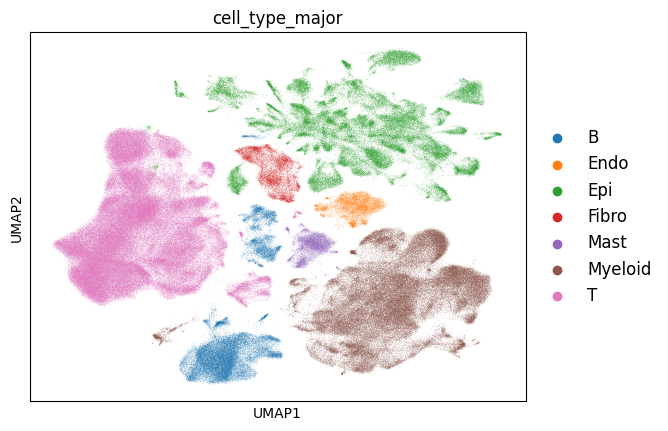

In [37]:
sc.pl.umap(adata, color=['cell_type_major'], legend_fontsize = 12)

In [44]:
plt.figure(figsize=(8, 6), dpi=600)
sc.pl.umap(adata, color=['cell_type_major'], legend_fontsize=12, show=False)
plt.savefig('umap_high_quality.png', dpi=600)
plt.close()

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Figure size 4800x3600 with 0 Axes>

In [ ]:
# adata 인덱스와 교집합을 찾아 'cell_type_major' 값을 'T cell'로 변경
common_indexes = tandnk_indexes.intersection(adata.obs.index)
adata.obs.loc[common_indexes, 'cell_type_major'] = 'T cell'

In [18]:
adata.obs.cell_type_major.value_counts()

cell_type_major
T cell              199498
Myeloid cell        122355
Epithelial cell      88173
B cell               41004
Fibroblast           12162
Endothelial cell      9945
Mast cell             9214
Name: count, dtype: int64

### EC subtype identification

In [61]:
adata

AnnData object with n_obs × n_vars = 482351 × 36601
    obs: 'n_counts', 'n_genes', 'mito', 'Dataset', 'Organ_orig', 'Organ', 'Sample', 'Patient', 'Subtype', 'Tissue_site', 'Tissue', 'CancerType', 'DataOrgTis', 'PtOrgTis', 'SpOrgTis', 'leiden', 'cnv_status', 'cnv_leiden', 'cnv_score', 'cell_type_major', 'cell_type_minor', 'cell_type_subset'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'chromosome', 'start', 'end', 'gene_id', 'gene_name'
    uns: 'anno_2212_colors', 'anno_cat_colors', 'cnv', 'cnv_leiden_colors', 'cnv_neighbors', 'cnv_status_colors', 'hvg', 'leiden', 'neighbors', 'pca', 'umap', 'cell_type_minor_colors', 'cell_type_subset_colors'
    obsm: 'X_cnv', 'X_cnv_pca', 'X_cnv_umap', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'cnv_neighbors_connectivities', 'cnv_neighbors_distances', 'connectivities', 'distances'

In [17]:
adata.obs.cell_type_major.value_counts()

cell_type_major
TandNK         198923
Myeloid        131640
Epithelial      88923
B               40659
Fibro_Peri      12174
Endothelial     10032
Name: count, dtype: int64

In [18]:
# endo 추출
adata_endo = adata[adata.obs['cell_type_major'] == 'Endothelial'].copy()
adata_endo

AnnData object with n_obs × n_vars = 10032 × 36601
    obs: 'n_counts', 'n_genes', 'mito', 'Dataset', 'Organ_orig', 'Organ', 'Sample', 'Patient', 'Subtype', 'Tissue_site', 'Tissue', 'CancerType', 'DataOrgTis', 'PtOrgTis', 'SpOrgTis', 'leiden', 'cnv_status', 'cnv_leiden', 'cnv_score', 'anno_2402', 'cell_type_major'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'chromosome', 'start', 'end', 'gene_id', 'gene_name'
    uns: 'anno_2212_colors', 'anno_cat_colors', 'cnv', 'cnv_leiden_colors', 'cnv_neighbors', 'cnv_status_colors', 'hvg', 'leiden', 'neighbors', 'pca', 'umap', 'leiden_colors', 'anno_2402_colors'
    obsm: 'X_cnv', 'X_cnv_pca', 'X_cnv_umap', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'cnv_neighbors_connectivities', 'cnv_neighbors_distances', 'connectivities', 'distances'

In [21]:
# TEC, NEC 세포 유형 식별
X_endo = adata_endo.to_df()

## Marker file to use
mkr_file = '/home/nccpml/DATA2/hanbyeol/TEC/cell_markers_EC.tsv'

# df_pred, summary = \
#     HiCAT( X, marker_file = mkr_file, log_transformed = False,
#                    Clustering_algo = 'lv', Clustering_resolution = 1, 
#                    Target_FPR = 0.05, pval_th = 0.05,
#                    target_cell_types = [], ## all in the db
#                    minor_types_to_exclude = [], N_neighbors_minor = 21,
#                    N_neighbors_subset = 1, cycling_cell = False, 
#                    verbose = False )

target_tissues = [] # ['Immune', 'General']
target_cell_types = ['Endothelial cell'] 
to_exclude = [] 

df_pred, summary = \
    HiCAT( X_endo, mkr_file, log_transformed = False,
           target_tissues = target_tissues, target_cell_types = target_cell_types, 
               minor_types_to_exclude = to_exclude, mkr_selector = '100000', 
               N_neighbors_minor = 31, N_neighbors_subset = 1,  
               Clustering_algo = 'lv', Clustering_resolution = 1, 
               Clustering_base = 'pca', N_pca_components = 15, 
               cbc_cutoff = 0.01, Target_FPR = 0.05, pval_th = 0.05,
               cycling_cell = False, copy_X = False, verbose = False )


HiCAT running ...

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_xsm = xsm[odr[lc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_xsm = xsm[odr[uc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1229: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '100.15987220439132' has dtype incompatible with float32, please explicitly cast to a compatible 

P71.C5..

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1501: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Endothelial cell' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  y_pred[:] = df_score.columns.values[0]


.M47.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_xsm = xsm[odr[lc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_xsm = xsm[odr[uc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1229: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '100.15987220439132' has dtype incompatible with float32, please explicitly cast to a compatible 

.M212.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.58881195 3.4456016  6.79217306 ... 4.01799068 3.28486206 0.86620281]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_GSA_score_minor_all.loc[idxs, cols] = df_GSA_score_cur
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:3086: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 6.53289174 10.84945401  5.21067094 ...  8.33468309  6.13675202
  1.97003136]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_GSA_score_minor_all.loc[idxs, cols] = df_GSA_score_cur
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1200: FutureWarning: Series.__getitem__ 

.

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_xsm = xsm[odr[lc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1201: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_xsm = xsm[odr[uc]]
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/MarkerCount/hicat.py:1229: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '59.69087032369355' has dtype incompatible with float32, please explicitly cast to a compatible d

.S134. done. (468)


In [1]:
# # 'TEC'와 'NEC'가 이미 범주에 포함되어 있는지 확인하고 추가
# if 'TEC' not in adata_endo.obs['cell_type_minor'].cat.categories:
#     adata_endo.obs['cell_type_minor'] = adata_endo.obs['cell_type_minor'].cat.add_categories('TEC')
# if 'NEC' not in adata_endo.obs['cell_type_minor'].cat.categories:
#     adata_endo.obs['cell_type_minor'] = adata_endo.obs['cell_type_minor'].cat.add_categories('NEC')

In [ ]:
# 'TEC'와 'NEC'가 이미 범주에 포함되어 있는지 확인하고 추가
if 'TEC' not in adata_endo.obs['cell_type_subset'].cat.categories:
    adata_endo.obs['cell_type_subset'] = adata_endo.obs['cell_type_subset'].cat.add_categories('Immature_Phenotype')
if 'NEC' not in adata_endo.obs['cell_type_subset'].cat.categories:
    adata_endo.obs['cell_type_subset'] = adata_endo.obs['cell_type_subset'].cat.add_categories('activated capillary')
if 'TEC' not in adata_endo.obs['cell_type_subset'].cat.categories:
    adata_endo.obs['cell_type_subset'] = adata_endo.obs['cell_type_subset'].cat.add_categories('Tip_Cells')
if 'NEC' not in adata_endo.obs['cell_type_subset'].cat.categories:
    adata_endo.obs['cell_type_subset'] = adata_endo.obs['cell_type_subset'].cat.add_categories('Activated_EC')
if 'TEC' not in adata_endo.obs['cell_type_subset'].cat.categories:
    adata_endo.obs['cell_type_subset'] = adata_endo.obs['cell_type_subset'].cat.add_categories('capillary type I')
if 'NEC' not in adata_endo.obs['cell_type_subset'].cat.categories:
    adata_endo.obs['cell_type_subset'] = adata_endo.obs['cell_type_subset'].cat.add_categories('capillary type II')

In [74]:
df_pred.cell_type_subset.value_counts()

cell_type_subset
activated capillary    4066
Immature_Phenotype     2288
capillary type I       1619
capillary type II       784
Tip_Cells               736
Activated_EC            539
Name: count, dtype: int64

In [75]:
df_pred.cell_type_minor.value_counts()

cell_type_minor
NEC    6469
TEC    3563
Name: count, dtype: int64

In [24]:
adata_endo.obs

n_counts  n_genes  \
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...    2941.0     1296   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...    8324.0     3080   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...    2171.0     1149   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...   14783.0     3488   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...    6242.0     1954   
...                                                      ...      ...   
pan_bluprint_lung_scrBT1431_TTTATGCTCATTCACT         10206.0     2827   
pan_bluprint_lung_scrBT1432_CACAAACGTATGAAAC         11405.0     2734   
pan_bluprint_lung_scrBT1432_CATGCCTTCCGTCAAA         16131.0     3478   
pan_bluprint_lung_scrBT1432_TGTATTCCACGACTCG          3822.0     1560   
pan_bluprint_lung_scrBT1432_TTATGCTTCCCTAATT          1221.0      599   

                                                        mito  \
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...  0.053705   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...  0.027387   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...  0.026243   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...  0.036255   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...  0.032196   
...                                                      ...   
pan_bluprint_lung_scrBT1431_TTTATGCTCATTCACT        0.049476   
pan_bluprint_lung_scrBT1432_CACAAACGTATGAAAC        0.030510   
pan_bluprint_lung_scrBT1432_CATGCCTTCCGTCAAA        0.006819   
pan_bluprint_lung_scrBT1432_TGTATTCCACGACTCG        0.113523   
pan_bluprint_lung_scrBT1432_TTATGCTTCCCTAATT        0.009002   

                                                                        Dataset  \
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...                pan_GSE140819   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...                pan_GSE140819   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...                pan_GSE140819   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...                pan_GSE140819   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...                pan_GSE140819   
...                                                                         ...   
pan_bluprint_lung_scrBT1431_TTTATGCTCATTCACT        lu_nsclc_pan_blueprint_lung   
pan_bluprint_lung_scrBT1432_CACAAACGTATGAAAC        lu_nsclc_pan_blueprint_lung   
pan_bluprint_lung_scrBT1432_CATGCCTTCCGTCAAA        lu_nsclc_pan_blueprint_lung   
pan_bluprint_lung_scrBT1432_TGTATTCCACGACTCG        lu_nsclc_pan_blueprint_lung   
pan_bluprint_lung_scrBT1432_TTATGCTTCCCTAATT        lu_nsclc_pan_blueprint_lung   

                                                   Organ_orig        Organ  \
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...       Lung  Lung Cancer   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...       Lung  Lung Cancer   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...       Lung  Lung Cancer   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...       Lung  Lung Cancer   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...       Lung  Lung Cancer   
...                                                       ...          ...   
pan_bluprint_lung_scrBT1431_TTTATGCTCATTCACT             Lung  Lung Cancer   
pan_bluprint_lung_scrBT1432_CACAAACGTATGAAAC             Lung  Lung Cancer   
pan_bluprint_lung_scrBT1432_CATGCCTTCCGTCAAA             Lung  Lung Cancer   
pan_bluprint_lung_scrBT1432_TGTATTCCACGACTCG             Lung  Lung Cancer   
pan_bluprint_lung_scrBT1432_TTATGCTTCCCTAATT             Lung  Lung Cancer   

                                                                                    Sample  \
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...  GSM4186959_NSCLC17_fresh-PDEC_channel1   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...  GSM4186959_NSCLC17_fresh-PDEC_channel1   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...  GSM4186959_NSCLC17_fresh-PDEC_channel1   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...  GSM4186959_NSCLC17_fresh-PDEC_channel1   
pa

In [23]:
# adata_endo.obs['cell_type_minor'] = 'unassigned'
# adata_endo.obs['cell_type_subset'] = 'unassigned'

types_df = df_pred[['cell_type_minor', 'cell_type_subset']]
# 인덱스를 기존 adata.obs와 일치시킴
types_df.index = adata_endo.obs.index

adata_endo.obs.loc[types_df.index, ['cell_type_minor', 'cell_type_subset']] = types_df[['cell_type_minor', 'cell_type_subset']]

/tmp/ipykernel_3276120/2873905338.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['TEC' 'TEC' 'NEC' ... 'TEC' 'TEC' 'TEC']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  adata_endo.obs.loc[types_df.index, ['cell_type_minor', 'cell_type_subset']] = types_df[['cell_type_minor', 'cell_type_subset']]
/tmp/ipykernel_3276120/2873905338.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['Activated_EC' 'Tip_Cells' 'activated capillary' ... 'Tip_Cells'
 'Activated_EC' 'Immature_Phenotype']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  adata_endo.obs.loc[types_df.index, ['cell_type_minor', 'cell_type_subset']] = types_df[['cell_type_minor', 'cell_type_subset']]


In [25]:
adata_endo.obs.cell_type_major.value_counts()

cell_type_major
Endothelial    10032
Name: count, dtype: int64

In [26]:
adata_endo.obs.cell_type_subset.value_counts()

cell_type_subset
activated capillary    4066
Immature_Phenotype     2288
capillary type I       1619
capillary type II       784
Tip_Cells               736
Activated_EC            539
Name: count, dtype: int64

In [27]:
adata_endo.obs.cell_type_minor.value_counts()

cell_type_minor
NEC    6469
TEC    3563
Name: count, dtype: int64

In [ ]:
type = 'cell_type_minor'  # 'cell_type_major', 'cell_type_minor'

# cell_type_major 열의 값 카운트
cell_type_counts = adata_endo.obs[type].value_counts()

# 0이 아닌 카운트를 가진 카테고리만 선택
non_zero_cell_types = cell_type_counts[cell_type_counts > 0].index

# 0이 아닌 카테고리만을 가진 데이터프레임 생성
adata_endo = adata_endo[adata_endo.obs[type].isin(non_zero_cell_types)].copy()

# 필터링된 데이터에서 cell_type_major 값의 분포를 다시 확인
print(adata_endo.obs[type].value_counts())

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


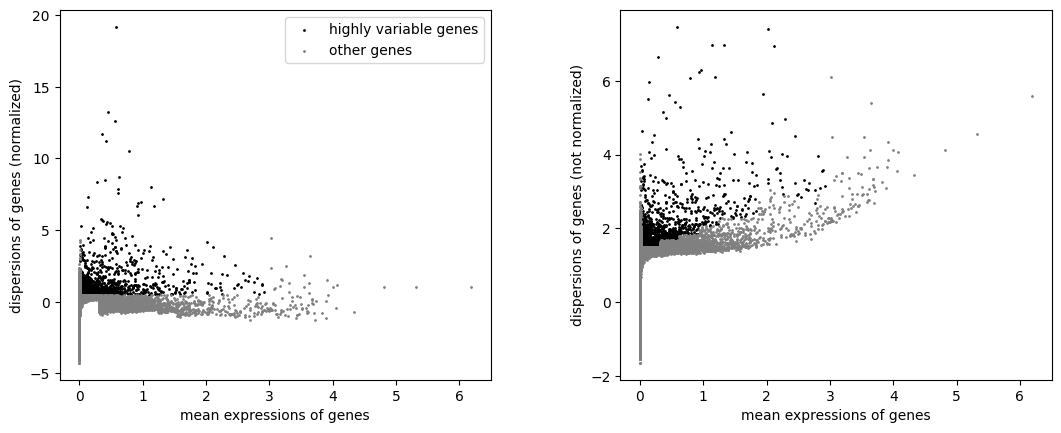

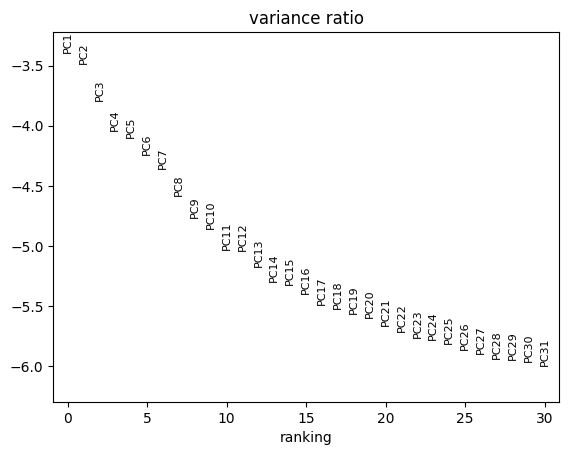

2024-04-24 07:56:05.177363: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-24 07:56:05.324917: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-24 07:56:05.324980: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-24 07:56:05.327092: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-24 07:56:05.371305: I tensorflow/core/platform/cpu_feature_guar

In [28]:
sc.pp.highly_variable_genes(adata_endo, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata_endo)
sc.tl.pca(adata_endo, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_endo, log=True)
sc.pp.neighbors(adata_endo, n_neighbors=10, n_pcs=40)
sc.tl.leiden(adata_endo)
sc.tl.umap(adata_endo)

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


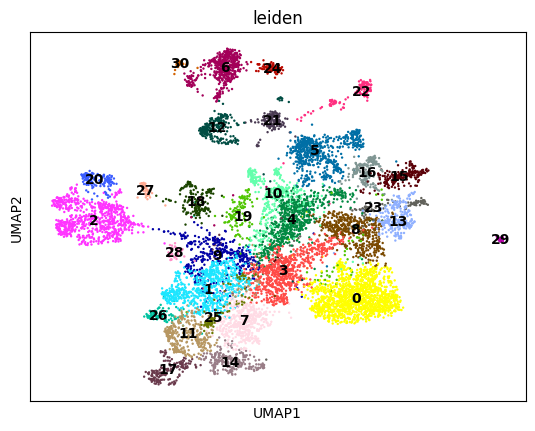

In [29]:
sc.pl.umap(adata_endo,color=['leiden'], legend_loc="on data")

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


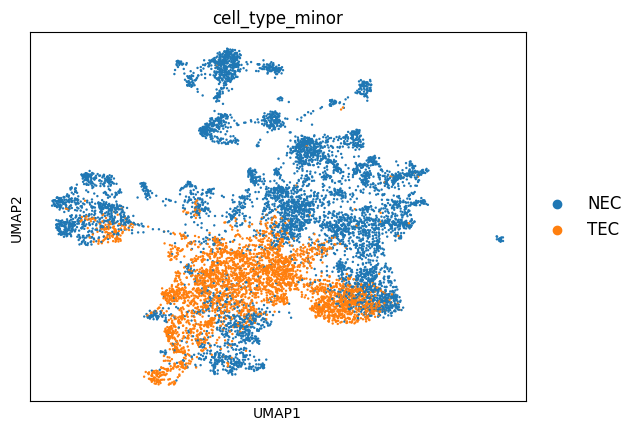

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


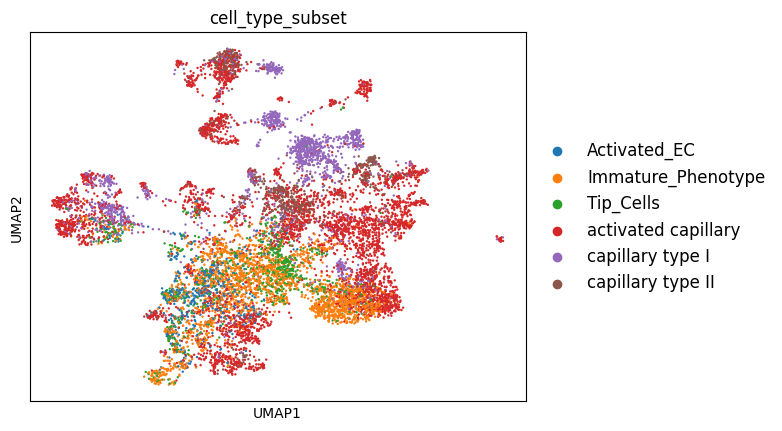

/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/hanbyeol/.conda/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


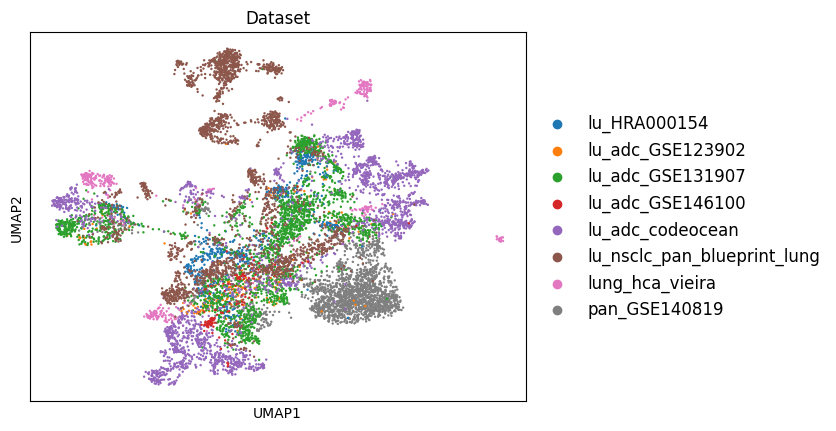

In [30]:
sc.pl.umap(adata_endo, color=['cell_type_minor'], legend_fontsize = 12)
sc.pl.umap(adata_endo, color=['cell_type_subset'], legend_fontsize = 12)
sc.pl.umap(adata_endo, color=['Dataset'], legend_fontsize = 12)

In [31]:
adata_endo.obs.Dataset.value_counts()

Dataset
lu_nsclc_pan_blueprint_lung    2290
lu_adc_GSE131907               2200
lu_adc_codeocean               2131
pan_GSE140819                  1937
lu_HRA000154                    642
lung_hca_vieira                 463
lu_adc_GSE123902                236
lu_adc_GSE146100                133
Name: count, dtype: int64

In [32]:
adata_endo.obs.cell_type_subset.value_counts()

cell_type_subset
activated capillary    4066
Immature_Phenotype     2288
capillary type I       1619
capillary type II       784
Tip_Cells               736
Activated_EC            539
Name: count, dtype: int64

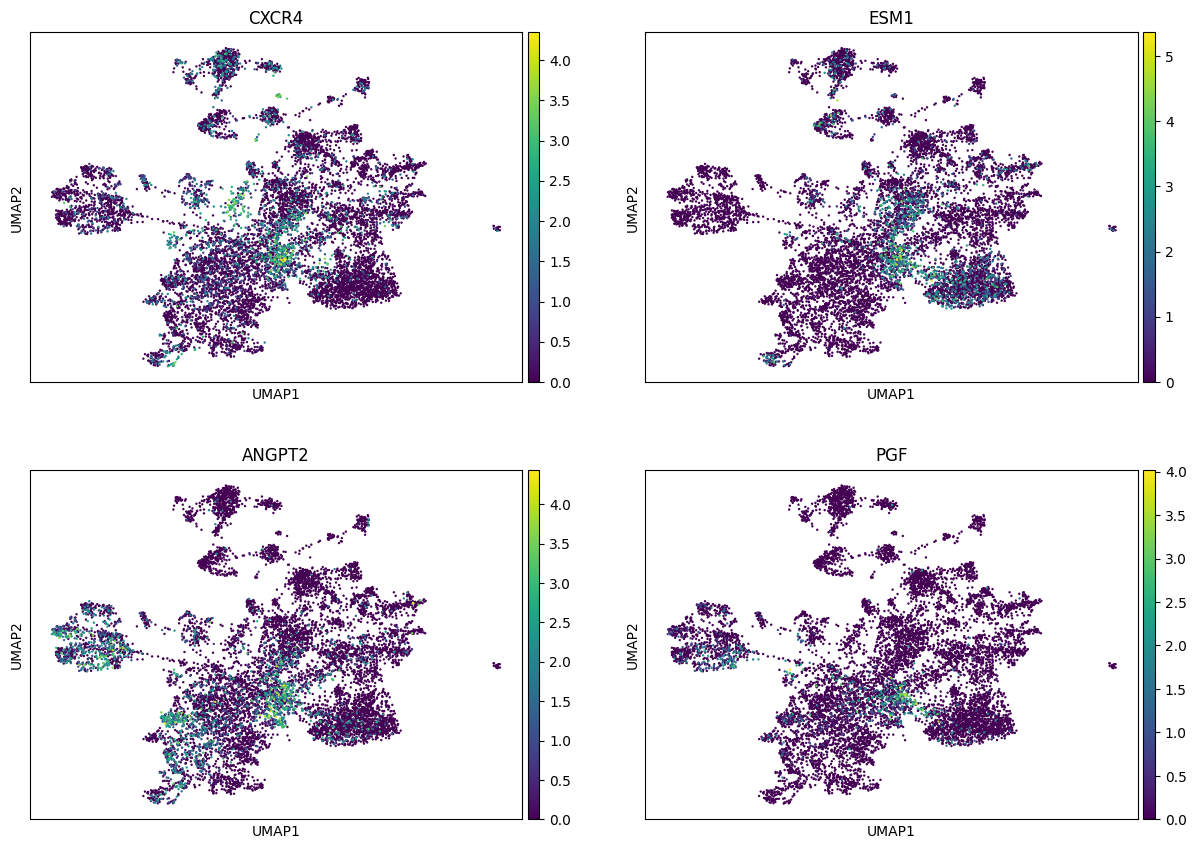

In [33]:
mk_geneset = ['CXCR4', 'ESM1', 'ANGPT2', 'PGF']
sc.pl.umap(adata_endo, color=mk_geneset, ncols=2)

In [34]:
## adata에 endo cell subtype 적용

In [35]:
adata.obs['cell_type_minor'] = adata.obs['cell_type_major']
adata.obs['cell_type_subset'] = adata.obs['cell_type_major']

In [36]:
adata.obs

n_counts  n_genes  \
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...    7088.0     2072   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...    4985.0     1269   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...   10007.0     2543   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...   18045.0     4597   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...    4937.0     1492   
...                                                      ...      ...   
pan_bluprint_lung_scrBT1432_TTTGCGCAGAGACTTA          2749.0      953   
pan_bluprint_lung_scrBT1432_TTTGCGCTCTTCAACT          6028.0     1639   
pan_bluprint_lung_scrBT1432_TTTGGTTCATTCTCAT          5192.0     1419   
pan_bluprint_lung_scrBT1432_TTTGTCACACATGTGT          1760.0      625   
pan_bluprint_lung_scrBT1432_TTTGTCATCGCGGATC          6131.0      766   

                                                        mito  \
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...  0.047256   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...  0.024067   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...  0.049760   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...  0.040231   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...  0.034629   
...                                                      ...   
pan_bluprint_lung_scrBT1432_TTTGCGCAGAGACTTA        0.031273   
pan_bluprint_lung_scrBT1432_TTTGCGCTCTTCAACT        0.023221   
pan_bluprint_lung_scrBT1432_TTTGGTTCATTCTCAT        0.039091   
pan_bluprint_lung_scrBT1432_TTTGTCACACATGTGT        0.021579   
pan_bluprint_lung_scrBT1432_TTTGTCATCGCGGATC        0.008154   

                                                                        Dataset  \
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...                pan_GSE140819   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...                pan_GSE140819   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...                pan_GSE140819   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...                pan_GSE140819   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...                pan_GSE140819   
...                                                                         ...   
pan_bluprint_lung_scrBT1432_TTTGCGCAGAGACTTA        lu_nsclc_pan_blueprint_lung   
pan_bluprint_lung_scrBT1432_TTTGCGCTCTTCAACT        lu_nsclc_pan_blueprint_lung   
pan_bluprint_lung_scrBT1432_TTTGGTTCATTCTCAT        lu_nsclc_pan_blueprint_lung   
pan_bluprint_lung_scrBT1432_TTTGTCACACATGTGT        lu_nsclc_pan_blueprint_lung   
pan_bluprint_lung_scrBT1432_TTTGTCATCGCGGATC        lu_nsclc_pan_blueprint_lung   

                                                   Organ_orig        Organ  \
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...       Lung  Lung Cancer   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...       Lung  Lung Cancer   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...       Lung  Lung Cancer   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...       Lung  Lung Cancer   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...       Lung  Lung Cancer   
...                                                       ...          ...   
pan_bluprint_lung_scrBT1432_TTTGCGCAGAGACTTA             Lung  Lung Cancer   
pan_bluprint_lung_scrBT1432_TTTGCGCTCTTCAACT             Lung  Lung Cancer   
pan_bluprint_lung_scrBT1432_TTTGGTTCATTCTCAT             Lung  Lung Cancer   
pan_bluprint_lung_scrBT1432_TTTGTCACACATGTGT             Lung  Lung Cancer   
pan_bluprint_lung_scrBT1432_TTTGTCATCGCGGATC             Lung  Lung Cancer   

                                                                                    Sample  \
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...  GSM4186959_NSCLC17_fresh-PDEC_channel1   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...  GSM4186959_NSCLC17_fresh-PDEC_channel1   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...  GSM4186959_NSCLC17_fresh-PDEC_channel1   
pan_GSE140819_GSM4186959_NSCLC17_fresh-PDEC_cha...  GSM4186959_NSCLC17_fresh-PDEC_channel1   
pa

In [37]:
adata.obs['cell_type_minor'].value_counts()

cell_type_minor
TandNK         198923
Myeloid        131640
Epithelial      88923
B               40659
Fibro_Peri      12174
Endothelial     10032
Name: count, dtype: int64

In [38]:
adata.obs['cell_type_minor'].replace('Endothelial', 'unassigned', inplace=True)

/tmp/ipykernel_3276120/310942007.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  adata.obs['cell_type_minor'].replace('Endothelial', 'unassigned', inplace=True)
/tmp/ipykernel_3276120/310942007.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs['cell_type_minor'].replace('Endothelial', 'unassigned', i

In [40]:
# 'TEC'와 'NEC'가 이미 범주에 포함되어 있는지 확인하고 추가
if 'TEC' not in adata.obs['cell_type_minor'].cat.categories:
    adata.obs['cell_type_minor'] = adata.obs['cell_type_minor'].cat.add_categories('TEC')
if 'NEC' not in adata.obs['cell_type_minor'].cat.categories:
    adata.obs['cell_type_minor'] = adata.obs['cell_type_minor'].cat.add_categories('NEC')

# 'TEC'와 'NEC' 인 인덱스 추출
tec_index = adata_endo.obs['cell_type_minor'] == 'TEC'
nec_index = adata_endo.obs['cell_type_minor'] == 'NEC'

# 두 인덱스를 합칩니다.
combined_index = tec_index | nec_index

# adata에서 'unassigned' 인 인덱스
unassigned_index = adata.obs['cell_type_minor'] == 'unassigned'

# 'unassigned' 인 위치를 'TEC'와 'NEC'로 업데이트
# adata_endo에서 해당 인덱스의 값을 가져오기 위해 numpy 배열로 변환
new_values = adata_endo.obs.loc[combined_index, 'cell_type_minor'].to_numpy()

# adata의 해당 인덱스에 new_values 할당
adata.obs.loc[unassigned_index, 'cell_type_minor'] = new_values


In [41]:
adata.obs['cell_type_subset'].value_counts()

cell_type_subset
TandNK         198923
Myeloid        131640
Epithelial      88923
B               40659
Fibro_Peri      12174
Endothelial     10032
Name: count, dtype: int64

In [42]:
# 'Endothelial cell' 인 인덱스
endo_index = adata.obs['cell_type_subset'] == 'Endothelial'

# 'TEC'와 'NEC'가 이미 범주에 포함되어 있는지 확인하고 추가
if 'TEC' not in adata.obs['cell_type_subset'].cat.categories:
    adata.obs['cell_type_subset'] = adata.obs['cell_type_subset'].cat.add_categories('activated capillary')
if 'TEC' not in adata.obs['cell_type_subset'].cat.categories:
    adata.obs['cell_type_subset'] = adata.obs['cell_type_subset'].cat.add_categories('Immature_Phenotype')
if 'TEC' not in adata.obs['cell_type_subset'].cat.categories:
    adata.obs['cell_type_subset'] = adata.obs['cell_type_subset'].cat.add_categories('capillary type I')
if 'TEC' not in adata.obs['cell_type_subset'].cat.categories:
    adata.obs['cell_type_subset'] = adata.obs['cell_type_subset'].cat.add_categories('capillary type II')
if 'TEC' not in adata.obs['cell_type_subset'].cat.categories:
    adata.obs['cell_type_subset'] = adata.obs['cell_type_subset'].cat.add_categories('Tip_Cells')
if 'NEC' not in adata.obs['cell_type_subset'].cat.categories:
    adata.obs['cell_type_subset'] = adata.obs['cell_type_subset'].cat.add_categories('Activated_EC')

# 각 인덱스를 결합합니다.
combined_index = (
    (adata_endo.obs['cell_type_subset'] == 'activated capillary') |
    (adata_endo.obs['cell_type_subset'] == 'Immature_Phenotype') |
    (adata_endo.obs['cell_type_subset'] == 'capillary type I') |
    (adata_endo.obs['cell_type_subset'] == 'capillary type II') |
    (adata_endo.obs['cell_type_subset'] == 'Tip_Cells') |
    (adata_endo.obs['cell_type_subset'] == 'Activated_EC')
)

# 해당 인덱스의 값을 가져옵니다.
new_values = adata_endo.obs.loc[combined_index, 'cell_type_subset'].to_numpy()

# 인덱스 길이가 동일한지 확인하고, 업데이트 진행
if len(new_values) == np.sum(endo_index):
    adata.obs.loc[endo_index, 'cell_type_subset'] = new_values
else:
    print("Error: The number of target entries does not match the number of values to assign.")
    print(f"Length of new_values: {len(new_values)}, Number of 'Endothelial cell' entries: {np.sum(endo_index)}")


In [44]:
adata.obs['cell_type_subset'].value_counts()

cell_type_subset
TandNK                 198923
Myeloid                131640
Epithelial              88923
B                       40659
Fibro_Peri              12174
activated capillary      4066
Immature_Phenotype       2288
capillary type I         1619
capillary type II         784
Tip_Cells                 736
Activated_EC              539
Name: count, dtype: int64

In [45]:
adata.obs['cell_type_minor'].value_counts()

cell_type_minor
TandNK        198923
Myeloid       131640
Epithelial     88923
B              40659
Fibro_Peri     12174
NEC             6469
TEC             3563
Name: count, dtype: int64

In [46]:
adata.obs['cell_type_major'].value_counts()

cell_type_major
TandNK         198923
Myeloid        131640
Epithelial      88923
B               40659
Fibro_Peri      12174
Endothelial     10032
Name: count, dtype: int64

In [57]:
adata1.obs['anno_2212'].value_counts()

anno_2212
Epithelial                            88935
CD8+ T-cell                           57778
CD4+ T-cell                           51176
PPARG+ macrophage                     42983
CD16+ NK-cell                         35560
C1QC+ macrophage                      32977
B                                     31219
Tissue resident memory T-cell         14035
Exhausted CD8+ T-cell                 13151
Treg                                  12213
NLRP3+ monocyte derived macrophage    10811
CXCL9+ macrophage                     10719
Mast                                   9444
Plasma cell                            8020
DC2                                    5967
FCN1+ monocyte derived macrophage      5397
Tfh                                    5152
XCL1+ NK-cell                          4860
Endothelial                            4434
Capillary aerocyte                     4425
PI16+ fibroblast                       3586
CD16+ monocyte derived macrophage      3476
SPP1+ macrophage      

In [55]:
adata1

AnnData object with n_obs × n_vars = 482351 × 36601
    obs: 'n_counts', 'n_genes', 'mito', 'doublet_scores', 'predicted_doublets', 'Dataset', 'Anno_low', 'Anno_high', 'Organ_orig', 'Organ', 'Platform', 'Sample', 'Patient', 'Subtype', 'Tissue_site', 'Tissue', 'Meta_site', 'Treatment', 'Immunotherapy', 'Response', 'CancerType', 'CancerAbbr', 'DataOrgTis', 'PtOrgTis', 'SpOrgTis', 'OrgTis', 'leiden', 'Sample_Origin', 'Status', 'Diagnosis', 'anno_new', 'cnv_status', 'anno_final2207', 'anno_figure', 'anno_specific', 'anno_fig_specific', 'anno_2211', 'F1C', 'anno_cat', 'anno_2212', 'cnv_leiden', 'cnv_score', 'anno_2402'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'chromosome', 'start', 'end', 'gene_id', 'gene_name'
    uns: 'anno_2212_colors', 'anno_2402_colors', 'anno_cat_colors', 'cnv', 'cnv_leiden_colors', 'cnv_neighbors', 'cnv_status_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_cnv', 'X_cnv_pca', 'X_cnv_umap', 'X_pca', 'X_

In [56]:
adata

AnnData object with n_obs × n_vars = 482351 × 36601
    obs: 'n_counts', 'n_genes', 'mito', 'Dataset', 'Organ_orig', 'Organ', 'Sample', 'Patient', 'Subtype', 'Tissue_site', 'Tissue', 'CancerType', 'DataOrgTis', 'PtOrgTis', 'SpOrgTis', 'leiden', 'cnv_status', 'cnv_leiden', 'cnv_score', 'anno_2402', 'cell_type_major', 'cell_type_minor', 'cell_type_subset'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'chromosome', 'start', 'end', 'gene_id', 'gene_name'
    uns: 'anno_2212_colors', 'anno_2402_colors', 'anno_cat_colors', 'cell_type_minor_colors', 'cell_type_subset_colors', 'cnv', 'cnv_leiden_colors', 'cnv_neighbors', 'cnv_status_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_cnv', 'X_cnv_pca', 'X_cnv_umap', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'cnv_neighbors_connectivities', 'cnv_neighbors_distances', 'connectivities', 'distances'

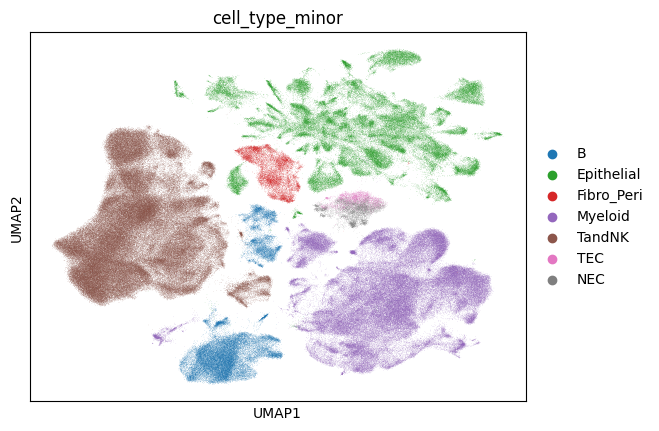

In [42]:
sc.pl.umap(adata, color='cell_type_minor', ncols=2)

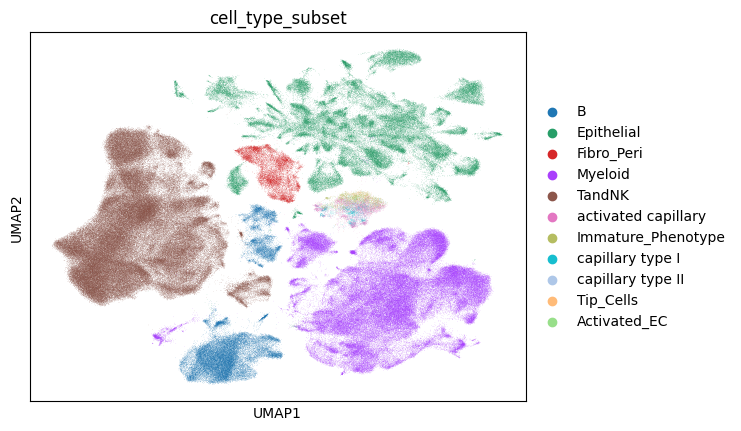

In [43]:
sc.pl.umap(adata, color='cell_type_subset', ncols=2)

In [48]:
## 0값 카테고리 지우기
# cell_type_major 열의 값 카운트
cell_type_counts = adata.obs['cell_type_minor'].value_counts()

# 0이 아닌 카운트를 가진 카테고리만 선택
non_zero_cell_types = cell_type_counts[cell_type_counts > 0].index

# 0이 아닌 카테고리만을 가진 데이터프레임 생성
adata = adata[adata.obs['cell_type_minor'].isin(non_zero_cell_types)].copy()

# cell_type_major 열의 값 카운트
cell_type_counts = adata.obs['cell_type_subset'].value_counts()

# 0이 아닌 카운트를 가진 카테고리만 선택
non_zero_cell_types = cell_type_counts[cell_type_counts > 0].index

# 0이 아닌 카테고리만을 가진 데이터프레임 생성
adata = adata[adata.obs['cell_type_subset'].isin(non_zero_cell_types)].copy()

In [6]:
# 저장
path = '/home/nccpml/DATA2/hanbyeol/TEC/h5ad_data/'
adata.write(path + 'CCA_Lung_reanno_0424.h5ad')

In [4]:
# 로드
path = '/home/nccpml/DATA2/hanbyeol/TEC/h5ad_data/'
adata1 = sc.read(path + 'HLCA_droplet_normal_lung_blood.h5ad')

In [5]:
adata1


AnnData object with n_obs × n_vars = 65662 × 26485
    obs: 'nGene', 'nUMI', 'orig.ident', 'channel', 'tissue', 'region', 'percent.ribo', 'free_annotation', 'patient', 'sample', 'location', 'magnetic.selection', 'preparation.site', 'compartment'
    obsm: 'X_Compartment_tSNE', 'X_tSNE'

In [9]:
adata1.obs

nGene  nUMI                  orig.ident channel tissue  \
index                                                                           
P2_1_AAACCTGAGAAACCAT   1347  2914  Human Lung 10x - Patient 2    P2_1   lung   
P2_1_AAATGCCAGATGAGAG   1713  4226  Human Lung 10x - Patient 2    P2_1   lung   
P2_1_AACACGTTCGATCCCT   1185  2152  Human Lung 10x - Patient 2    P2_1   lung   
P2_1_AACACGTTCGCACTCT   1378  3419  Human Lung 10x - Patient 2    P2_1   lung   
P2_1_AACCATGCAGCTCGCA   1210  2514  Human Lung 10x - Patient 2    P2_1   lung   
...                      ...   ...                         ...     ...    ...   
P3_6_TGTCCCAGTTCTGAAC    953  1525  Human Lung 10x - Patient 3    P3_6   lung   
P3_6_TTCTCCTTCTGTTTGT    999  1480  Human Lung 10x - Patient 3    P3_6   lung   
P3_7_AACTCCCCACTACAGT    651  1154  Human Lung 10x - Patient 3    P3_7   lung   
P3_7_TCGTAGATCATCGGAT   1050  1861  Human Lung 10x - Patient 3    P3_7   lung   
P3_4_GCTGCGAAGAGCTTCT   2218  4877  Human Lung 10x - Patient 3    P3_4   lung   

                       region  percent.ribo        free_annotation  patient  \
index                                                                         
P2_1_AAACCTGAGAAACCAT  normal      0.035347  Capillary Aerocyte_P2        2   
P2_1_AAATGCCAGATGAGAG  normal      0.061051  Capillary Aerocyte_P2        2   
P2_1_AACACGTTCGATCCCT  normal      0.048327  Capillary Aerocyte_P2        2   
P2_1_AACACGTTCGCACTCT  normal      0.032758  Capillary Aerocyte_P2        2   
P2_1_AACCATGCAGCTCGCA  normal      0.050119  Capillary Aerocyte_P2        2   
...                       ...           ...                    ...      ...   
P3_6_TGTCCCAGTTCTGAAC  normal      0.091803            Pericyte_P3        3   
P3_6_TTCTCCTTCTGTTTGT  normal      0.065541            Pericyte_P3        3   
P3_7_AACTCCCCACTACAGT  normal      0.178510            Pericyte_P3        3   
P3_7_TCGTAGATCATCGGAT  normal      0.141322            Pericyte_P3        3   
P3_4_GCTGCGAAGAGCTTCT  normal      0.078532            Pericyte_P3        3   

                           sample  location      magnetic.selection  \
index                                                                 
P2_1_AAACCTGAGAAACCAT    distal 2    distal              epithelial   
P2_1_AAATGCCAGATGAGAG    distal 2    distal              epithelial   
P2_1_AACACGTTCGATCCCT    distal 2    distal              epithelial   
P2_1_AACACGTTCGCACTCT    distal 2    distal              epithelial   
P2_1_AACCATGCAGCTCGCA    distal 2    distal              epithelial   
...                           ...       ...                     ...   
P3_6_TGTCCCAGTTCTGAAC    distal 3    distal              epithelial   
P3_6_TTCTCCTTCTGTTTGT    distal 3    distal              epithelial   
P3_7_AACTCCCCACTACAGT    distal 3    distal  immune and endothelial   
P3_7_TCGTAGATCATCGGAT    distal 3    distal  immune and endothelial   
P3_4_GCTGCGAAGAGCTTCT  proximal 3  proximal                 stromal   

                      preparation.site  compartment  
index                                                
P2_1_AAACCTGAGAAACCAT           biohub  endothelial  
P2_1_AAATGCCAGATGAGAG           biohub  endothelial  
P2_1_AACACGTTCGATCCCT           biohub  endothelial  
P2_1_AACACGTTCGCACTCT           biohub  endothelial  
P2_1_AACCATGCAGCTCGCA           biohub  endothelial  
...                                ...          ...  
P3_6_TGTCCCAGTTCTGAAC           biohub      stromal  
P3_6_TTCTCCTTCTGTTTGT           biohub      stromal  
P3_7_AACTCCCCACTACAGT           biohub      stromal  
P3_7_TCGTAGATCATCGGAT           biohub      stromal  
P3_4_GCTGCGAAGAGCTTCT           biohub      stromal  

[65662 rows x 14 columns]

In [12]:
sc.pl.umap(adata1, color='magnetic.selection', ncols=2)

AttributeError: module 'scanpy.plotting' has no attribute 'tSNE'

In [16]:
adata1.obs['magnetic.selection'].value_counts()

magnetic.selection
epithelial                23525
stromal                   19655
immune and endothelial    17813
blood                      4669
Name: count, dtype: int64

In [7]:
# 로드
path = '/home/nccpml/DATA2/hanbyeol/TEC/h5ad_data/'
adata2 = sc.read(path + 'HLCA_facs_normal_lung_blood.h5ad')

In [8]:
adata2

AnnData object with n_obs × n_vars = 9409 × 60970
    obs: 'nGene', 'nReads', 'orig.ident', 'plate.barcode', 'cell.id', 'organism', 'tissue', 'region', 'label', 'sorter', 'sort.location', 'sample', 'location', 'patient', 'percent.ercc', 'percent.ribo', 'gating', 'free_annotation', 'Number of input reads', 'Uniquely mapped reads number', 'Number of splices: Total', 'Number of splices: Annotated (sjdb)', 'Number of splices: GT/AG', 'Number of splices: GC/AG', 'Number of splices: AT/AC', 'Number of splices: Non-canonical', 'Number of reads mapped to multiple loci', 'Number of reads mapped to too many loci', 'Number of chimeric reads', 'Mapping speed, Million of reads per hour', 'Average input read length', 'Uniquely mapped reads %', 'Average mapped length', 'Mismatch rate per base, %', 'Deletion rate per base', 'Deletion average length', 'Insertion rate per base', 'Insertion average length', '% of reads mapped to multiple loci', '% of reads mapped to too many loci', '% of reads unmapped: 

In [15]:
adata2.obs['sample'].value_counts()

sample
distal 2      1982
distal 1b     1642
distal 1a     1593
medial 2      1291
distal 3      1190
blood 1        752
medial 3       559
proximal 3     400
Name: count, dtype: int64

In [11]:
sc.pl.umap(adata2, color='magnetic.selection', ncols=2)

KeyError: "Could not find 'umap' or 'X_umap' in .obsm"

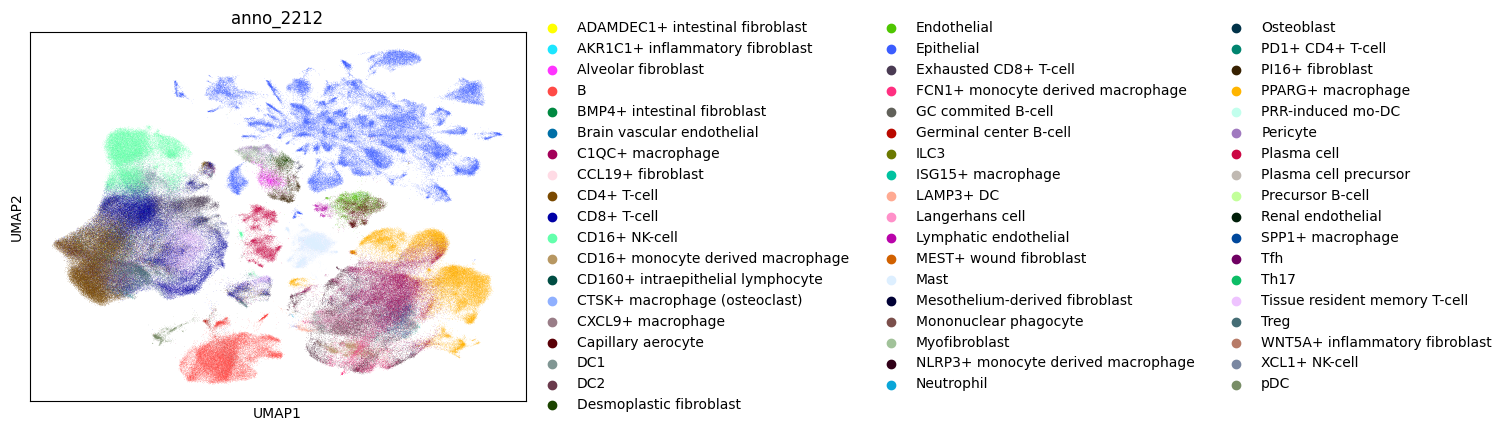

In [58]:
sc.pl.umap(adata1, color='anno_2212', ncols=2)

In [6]:
adata_endo = adata[adata.obs['cell_type_major'] == 'Endothelial'].copy()
adata_endo

AnnData object with n_obs × n_vars = 10032 × 36601
    obs: 'n_counts', 'n_genes', 'mito', 'Dataset', 'Organ_orig', 'Organ', 'Sample', 'Patient', 'Subtype', 'Tissue_site', 'Tissue', 'CancerType', 'DataOrgTis', 'PtOrgTis', 'SpOrgTis', 'leiden', 'cnv_status', 'cnv_leiden', 'cnv_score', 'anno_2402', 'cell_type_major', 'cell_type_minor', 'cell_type_subset'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'chromosome', 'start', 'end', 'gene_id', 'gene_name'
    uns: 'anno_2212_colors', 'anno_2402_colors', 'anno_cat_colors', 'cell_type_minor_colors', 'cell_type_subset_colors', 'cnv', 'cnv_leiden_colors', 'cnv_neighbors', 'cnv_status_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_cnv', 'X_cnv_pca', 'X_cnv_umap', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'cnv_neighbors_connectivities', 'cnv_neighbors_distances', 'connectivities', 'distances'

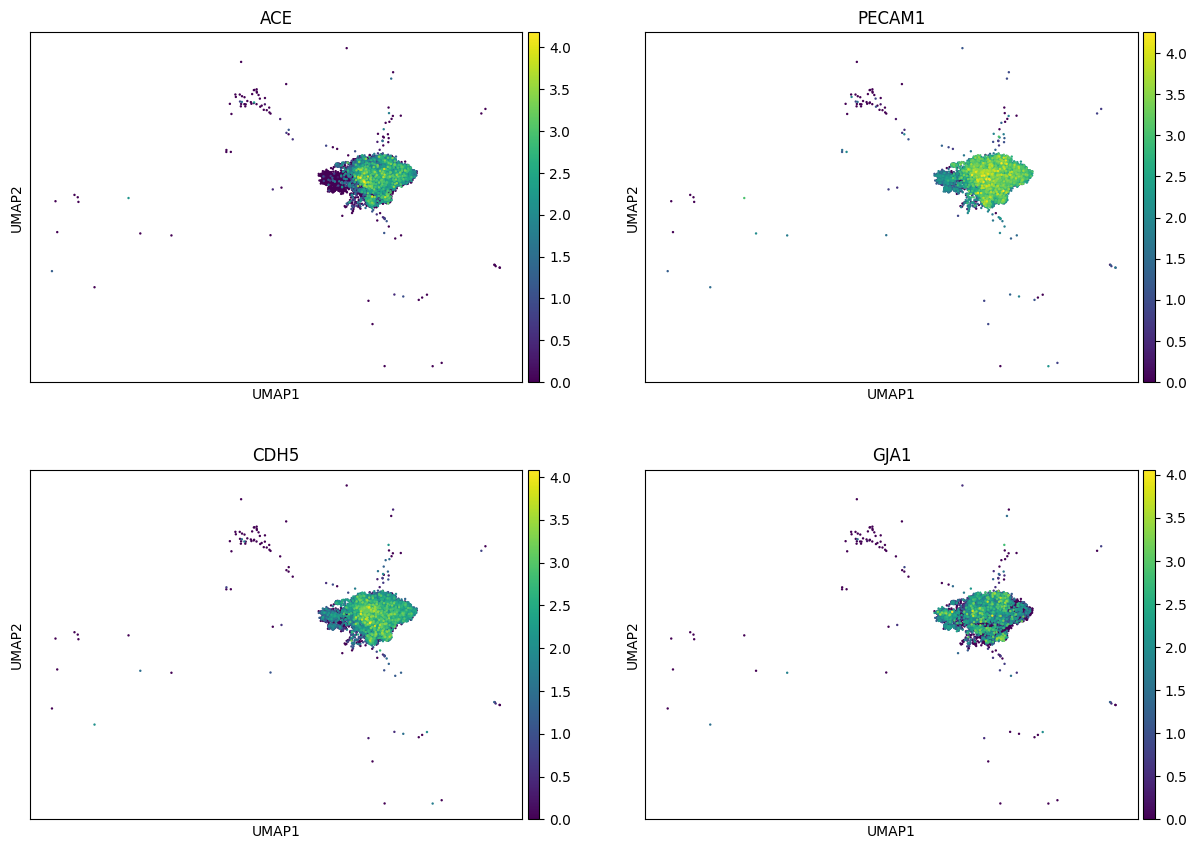

In [35]:
mk_geneset = ['ACE', 'PECAM1', 'CDH5', 'GJA1']
sc.pl.umap(adata_endo, color=mk_geneset, ncols=2)

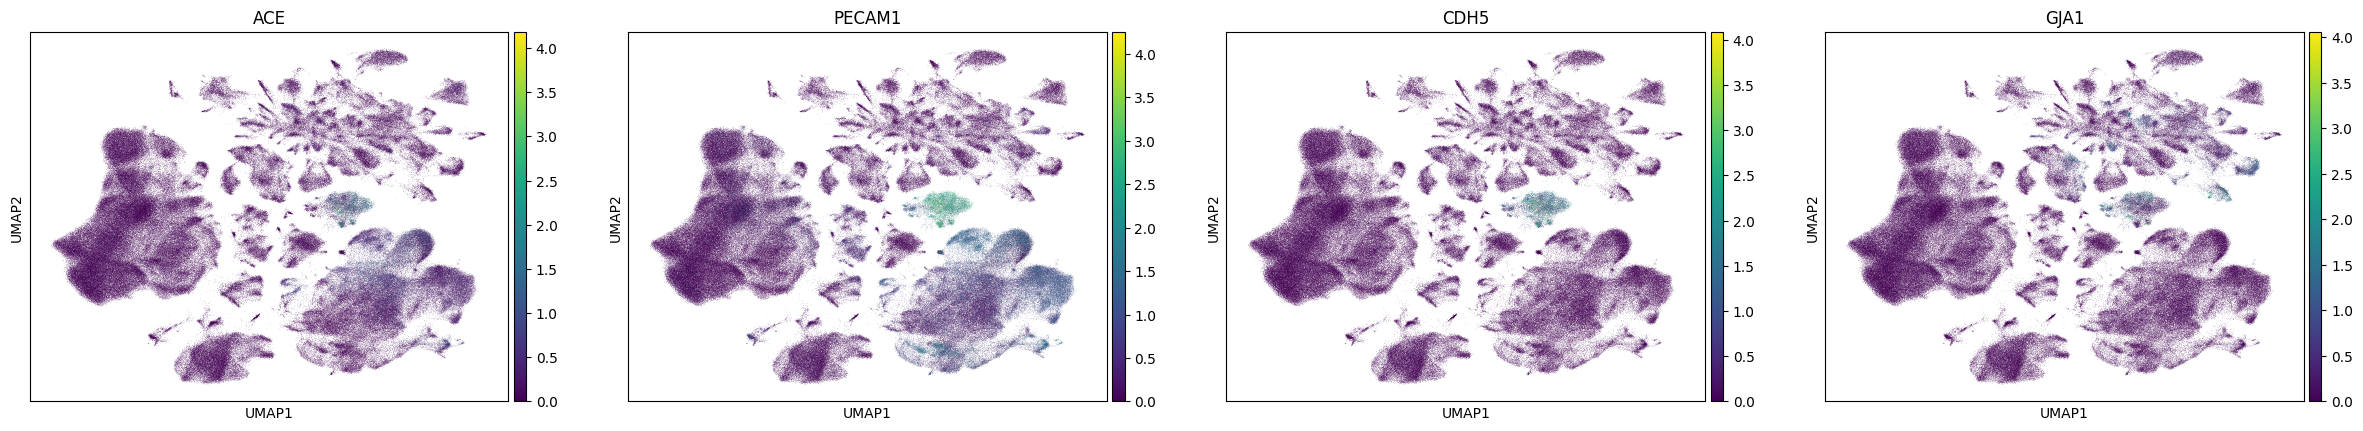

In [39]:
sc.pl.umap(adata, color=mk_geneset, ncols=4)